In [1]:
from scipy.io import wavfile
import numpy as np

file_path = "baseline_separated/separated_IB-02357_adolescent.wav"

# Read audio file
Fs, audio = wavfile.read(file_path)

# Convert to float for accurate stats if needed
if audio.dtype != np.float32 and audio.dtype != np.float64:
    # Normalize if integer type (e.g., int16)
    max_val = np.iinfo(audio.dtype).max
    audio = audio.astype(np.float32) / max_val

# Compute stats
min_amp = np.min(audio)
max_amp = np.max(audio)
mean_amp = np.mean(audio)

print(f"Audio stats for {file_path}:")
print(f"Min amplitude: {min_amp}")
print(f"Max amplitude: {max_amp}")
print(f"Mean amplitude: {mean_amp}")


Audio stats for baseline_separated/separated_IB-02357_adolescent.wav:
Min amplitude: -0.9150670170783997
Max amplitude: 0.4534134864807129
Mean amplitude: -0.0011667236685752869


# PREPROCESSING  - SHARED CELLS

In [1]:
from scipy.stats import pointbiserialr
import pandas as pd

# Initialize list to store results
results = []
df = pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"], errors="ignore")
df = df.apply(pd.to_numeric, errors="coerce")

target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]
df[target_columns] = df[target_columns].replace(2, 1)

In [52]:
from scipy.stats import pointbiserialr
import pandas as pd

# Initialize list to store results
results = []
df = pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"], errors="ignore")
df = df.apply(pd.to_numeric, errors="coerce")

target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]
df[target_columns] = df[target_columns].replace(2, 1)

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

results = []

for target in target_columns:
    group0 = df[df[target] == 0]
    group1 = df[df[target] == 1]

    correlations = []

    for feature in feature_cols:
        try:
            x0 = group0[feature].dropna()
            x1 = group1[feature].dropna()

            if len(x0) < 5 or len(x1) < 5:
                continue  # too few samples

            u_stat, p_value = mannwhitneyu(x0, x1, alternative='two-sided')
            median_diff = abs(np.median(x1) - np.median(x0))  # effect size
            correlations.append((feature, p_value, median_diff))
        except Exception:
            continue

    # Create DataFrame
    corr_df = pd.DataFrame(correlations, columns=["Feature", "P-value", "Effect Size (|median diff|)"])

    # Apply FDR correction
    _, pvals_corrected, _, _ = multipletests(corr_df["P-value"], alpha=0.05, method='fdr_bh')
    corr_df["FDR-corrected P-value"] = pvals_corrected
    corr_df["Significant"] = corr_df["FDR-corrected P-value"] < 0.05

    # Top 5 by effect size
    top_corrs = corr_df.sort_values(by="Effect Size (|median diff|)", ascending=False).head(5)

    for _, row in top_corrs.iterrows():
        results.append({
            "Target": target,
            "Feature": row["Feature"],
            "P-value": row["P-value"],
            "FDR-corrected P-value": row["FDR-corrected P-value"],
            "Effect Size (|median diff|)": row["Effect Size (|median diff|)"],
            "Significant": row["Significant"]
        })

# Final DataFrame
top_mw_df = pd.DataFrame(results)
top_mw_df = top_mw_df.sort_values(by=["Target", "Effect Size (|median diff|)"], ascending=[True, False])

# View top rows
print(top_mw_df.head(15))




             Target                 Feature   P-value  FDR-corrected P-value  \
35  T1_YSR_93_98_ab              t1_stdDDF2  0.920852               0.995577   
36  T1_YSR_93_98_ab       t1_paa_mfcc_4_max  0.230072               0.980715   
37  T1_YSR_93_98_ab         t1_stdMFCCoff_5  0.026781               0.980715   
38  T1_YSR_93_98_ab        t1_stdMFCCoff_10  0.049567               0.980715   
39  T1_YSR_93_98_ab         t1_stdDMFCCon_8  0.026602               0.980715   
0   T1_YSR_93_98_ad  t1_paa_deltamfcc_2_max  0.021914               0.545869   
1   T1_YSR_93_98_ad          t1_avgBBEoff_5  0.022128               0.545869   
2   T1_YSR_93_98_ad       t1_paa_mfcc_3_min  0.937584               0.992829   
3   T1_YSR_93_98_ad          t1_avgBBEoff_6  0.001095               0.370756   
4   T1_YSR_93_98_ad           t1_avgEvoiced  0.403449               0.809615   
25  T1_YSR_93_98_ap       t1_paa_mfcc_3_min  0.088636               0.905335   
26  T1_YSR_93_98_ap  t1_paa_deltamfcc_3_

In [53]:
# Calculate percentage of significant features
total = len(top_mw_df)
significant_count = top_mw_df["Significant"].sum()  # True counts as 1
percentage_significant = (significant_count / total) * 100

print(f"{significant_count} out of {total} features are significant after FDR correction.")
print(f"That's {percentage_significant:.2f}% of the top features.")


0 out of 55 features are significant after FDR correction.
That's 0.00% of the top features.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, balanced_accuracy_score, confusion_matrix,
    precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm

# Load data
df = pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"], errors="ignore")
df = df.apply(pd.to_numeric, errors="coerce")

target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]
df[target_columns] = df[target_columns].replace(2, 1)

# Define acoustic feature columns
feature_cols = df.columns[90:]

results = []

for target in tqdm(target_columns):
    data = df[[target] + list(feature_cols)].dropna()
    y = data[target]
    X = data[feature_cols]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select top k features
    selector = SelectKBest(score_func=mutual_info_classif, k=50)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train)
    X_test_sel = selector.transform(X_test_scaled)

    # Compute imbalance ratio
    neg, pos = np.bincount(y_train)
    scale = neg / pos

    # Define model
    model = XGBClassifier(
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='gpu_hist',  # or 'gpu_hist' if on GPU
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(X_train_sel, y_train)
    y_proba = model.predict_proba(X_test_sel)[:, 1]

    # Threshold tuning
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    idxs = np.where(recalls >= 0.7)[0]
    if len(idxs) > 0:
        precision_at_70recall = np.max(precisions[idxs])
    else:
        precision_at_70recall = np.nan

    # Predict at 0.5
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0. and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
    else:
        threshold = 0.5  # fallback

# Apply threshold
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Target": target,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn
    })

# Compile results
results_df = pd.DataFrame(results)
print(results_df)

# Optional: Save to Excel
# results_df.to_excel("xgboost_results_with_feature_selection.xlsx", index=False)


In [11]:
#THIS ONE IS THE FINAL ONE


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, balanced_accuracy_score, confusion_matrix,
    precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm

# Load data
# df= pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
# df = df.drop(columns=["helper"], errors="ignore")
# df= df.apply(pd.to_numeric, errors="coerce")

target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts', 'T1_YSR_sad_binary', 'T1_YSR_swd_binary',
       'T1_YSR_ssc_binary', 'T1_YSR_ssp_binary', 'T1_YSR_stp_binary',
       'T1_YSR_sap_binary', 'T1_YSR_srb_binary', 'T1_YSR_sab_binary',
       'T1_YSR_sip_binary', 'T1_YSR_sep_binary',
       'T1_YSR_sts_binary'
]

#df[target_columns] = df[target_columns].replace(2, 1)

# Define acoustic feature columns
feature_cols = df.columns[90:]

results = []

# Range of k values to test
k_values = [10, 25, 50, 75, 100]

for target in tqdm(target_columns):
    data = df[[target] + list(feature_cols)].dropna()
    y = data[target]
    X = data[feature_cols]

    # Train/test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Preprocess: scale
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation to select best k
    best_k = None
    best_f1 = -np.inf

    for k in k_values:
        f1s = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X_train_scaled, y_train_full):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

            selector = SelectKBest(mutual_info_classif, k=k)
            X_tr_sel = selector.fit_transform(X_tr, y_tr)
            X_val_sel = selector.transform(X_val)

            neg, pos = np.bincount(y_tr)
            scale = neg / pos

            model = XGBClassifier(
                scale_pos_weight=scale,
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='gpu_hist',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                random_state=42
            )
            model.fit(X_tr_sel, y_tr)
            y_val_pred = model.predict(X_val_sel)
            f1s.append(f1_score(y_val, y_val_pred, zero_division=0))

        avg_f1 = np.mean(f1s)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Retrain with best k on full training data
    selector = SelectKBest(mutual_info_classif, k=best_k)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train_full)
    X_test_sel = selector.transform(X_test_scaled)

    # 🔧 Extract selected feature names
    selected_features = X.columns[selector.get_support()].tolist()

    neg, pos = np.bincount(y_train_full)
    ratio = neg / pos

    scale = ratio if ratio > 1.5 else 1  # Apply only for significant imbalance

    model = XGBClassifier(
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(X_train_sel, y_train_full)
    y_proba = model.predict_proba(X_test_sel)[:, 1]

    # 🔧 Get feature importances from model
    importances = model.feature_importances_
    feature_importance_dict = dict(zip(selected_features, importances))
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    top5_features = sorted_importances[:5]

    top5_names = [f for f, _ in top5_features]
    top5_vals = [round(float(v), 4) for _, v in top5_features]
    top5_str = "; ".join([f"{name}: {val}" for name, val in zip(top5_names, top5_vals)])


    # Threshold tuning to achieve >=70% recall
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    idxs = np.where(recalls >= 0.7)[0]
    if len(idxs) > 0:
        precision_at_70recall = np.max(precisions[idxs])
    else:
        precision_at_70recall = np.nan

    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0. and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
    else:
        threshold = 0.5  # fallback

    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Target": target,
        "Best_k": best_k,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Selected_Features": "; ".join(selected_features),
        "Top5_Important_Features": top5_str
    })


# Compile results
results_df = pd.DataFrame(results)
print(results_df)

# Optional: Save to Excel
# results_df.to_excel("xgboost_bestk_final_results.xlsx", index=False)


  0%|          | 0/22 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [13:42:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


               Target  Best_k        F1  Balanced Accuracy  Precision  \
0     T1_YSR_93_98_ad      75  0.428571           0.640741   0.750000   
1     T1_YSR_93_98_wd     100  0.418605           0.617347   0.310345   
2     T1_YSR_93_98_sc      75  0.300000           0.593939   0.272727   
3     T1_YSR_93_98_sp      10  0.215385           0.552632   0.120690   
4     T1_YSR_93_98_tp      75  0.461538           0.669318   0.600000   
5     T1_YSR_93_98_ap      10  0.470588           0.654422   0.421053   
6     T1_YSR_93_98_rb      10  0.285714           0.687500   0.166667   
7     T1_YSR_93_98_ab      10  0.085106           0.647541   0.044444   
8     T1_YSR_93_98_ip     100  0.517647           0.500000   0.349206   
9     T1_YSR_93_98_ep      25  0.400000           0.638889   0.500000   
10    T1_YSR_93_98_ts      10  0.450704           0.557545   0.296296   
11  T1_YSR_sad_binary      50  0.682927           0.613725   0.538462   
12  T1_YSR_swd_binary     100  0.652632           0

In [12]:
results_df.to_csv("ALEXANDRA_XGBOOSTFEATURES_T1.csv", index=False)

In [11]:
results_df.to_csv("XGBOOST_FEATURES_T1.csv", index=False)

In [279]:
results_df.to_csv('XGboost_T1.csv', index=False)

In [5]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, balanced_accuracy_score,
    accuracy_score, confusion_matrix, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tqdm import tqdm
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"])
df = df.apply(pd.to_numeric, errors="coerce")


target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]
df[target_columns] = df[target_columns].replace(2, 1)
feature_cols = df.columns[90:]

# Resume processing loop with SMOTE fix
k_values = [30, 50, 100]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for target in tqdm(target_columns):
    data = df[[target] + list(feature_cols)].dropna()
    y_all = data[target]
    X_all = data[feature_cols]

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
    )

    best_f1 = -np.inf
    best_k = None
    best_threshold = 0.5

    for k in k_values:
        fold_metrics = []

        for train_idx, val_idx in cv.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
            y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            X_train_sel = selector.fit_transform(X_train_scaled, y_train)
            X_val_sel = selector.transform(X_val_scaled)

            minority_class = 1
            minority_count = sum(y_train == minority_class)
            k_smote = min(5, minority_count - 1) if minority_count > 1 else 1
            sm = SMOTE(random_state=42, k_neighbors=k_smote)
            X_train_bal, y_train_bal = sm.fit_resample(X_train_sel, y_train)

            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='hist',
                device='cuda',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                verbosity=0,
                random_state=42
            )
            model.fit(X_train_bal, y_train_bal)
            y_proba = model.predict_proba(X_val_sel)[:, 1]

            precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
            valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

            threshold = 0.5
            if valid_idxs:
                best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
                threshold = thresholds[best_idx]

            y_pred = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            fold_metrics.append(f1)

        avg_f1 = np.mean(fold_metrics)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Final training and test evaluation
    scaler = RobustScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_trainval_sel = selector.fit_transform(X_trainval_scaled, y_trainval)

    minority_count = sum(y_trainval == 1)
    k_smote = min(5, minority_count - 1) if minority_count > 1 else 1
    sm = SMOTE(random_state=42, k_neighbors=k_smote)
    X_trainval_bal, y_trainval_bal = sm.fit_resample(X_trainval_sel, y_trainval)

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        verbosity=0,
        random_state=42
    )
    model.fit(X_trainval_bal, y_trainval_bal)

    X_test_scaled = scaler.transform(X_test)
    X_test_sel = selector.transform(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_sel)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    threshold = 0.5
    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]

    y_pred_test = (y_proba_test >= threshold).astype(int)

    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    acc = accuracy_score(y_test, y_pred_test)
    precision_at_70 = precision if recall >= 0.7 else np.nan
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_all.columns[selected_feature_indices]
    importances = model.get_booster().get_score(importance_type='gain')
    feature_importance = {
    selected_feature_names[int(k[1:])]: v for k, v in importances.items()}


    results.append({
        "Target": target,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Threshold": threshold,
        "k": best_k,
        "Selected Features": list(selected_feature_names),
        "Feature Importances": feature_importance
    })

results_df = pd.DataFrame(results)


100%|██████████| 11/11 [05:42<00:00, 31.15s/it]


In [6]:
results_df

,Target,F1,Balanced Accuracy,Precision,Recall,Accuracy,Precision@70%Recall,TP,TN,FP,FN,Threshold,k,Selected Features,Feature Importances
0,T1_YSR_93_98_ad,0.315789,0.594444,0.333333,0.300000,0.796875,NaN,3,48,6,7,0.328271,50,"[t1_stdlogE, t1_avgMFCCon_7, t1_avgDDMFCCoff_8...","{'t1_stdlogE': 2.395508289337158, 't1_avgMFCCo..."
1,T1_YSR_93_98_wd,0.210526,0.540816,0.400000,0.142857,0.761905,NaN,2,46,3,12,0.500000,100,"[t1_kurtosisDDF0, t1_kurtosisapq, t1_kurtosisp...","{'t1_kurtosisDDF0': 1.8071848154067993, 't1_ku..."
2,T1_YSR_93_98_sc,0.333333,0.612121,0.333333,0.333333,0.812500,NaN,3,49,6,6,0.199615,30,"[t1_skewnessDF0, t1_avgBBEon_6, t1_avgBBEon_15...","{'t1_skewnessDF0': 1.938474416732788, 't1_avgB..."
3,T1_YSR_93_98_sp,0.166667,0.536341,0.200000,0.142857,0.843750,NaN,1,53,4,6,0.500000,50,"[t1_stdapq, t1_avgMFCCon_1, t1_avgDMFCCon_5, t...","{'t1_stdapq': 1.029375433921814, 't1_avgMFCCon..."
4,T1_YSR_93_98_tp,0.166667,0.535227,0.250000,0.125000,0.841270,NaN,1,52,3,7,0.500000,100,"[t1_skewnessDF0, t1_avgBBEon_18, t1_avgMFCCon_...","{'t1_skewnessDF0': 1.165035605430603, 't1_avgB..."
5,T1_YSR_93_98_ap,0.368421,0.570068,0.304348,0.466667,0.625000,NaN,7,33,16,8,0.187546,50,"[t1_avgBBEon_18, t1_avgDDMFCCon_1, t1_avgDDMFC...","{'t1_avgBBEon_18': 1.1423739194869995, 't1_avg..."
6,T1_YSR_93_98_rb,0.000000,0.464286,0.000000,0.000000,0.825397,NaN,0,52,4,7,0.500000,30,"[t1_avgMFCCon_2, t1_avgMFCCon_9, t1_stdDMFCCon...","{'t1_avgMFCCon_2': 1.6700494289398193, 't1_avg..."
7,T1_YSR_93_98_ab,0.000000,0.500000,0.000000,0.000000,0.968254,NaN,0,61,0,2,0.500000,100,"[t1_stdlogE, t1_avgBBEon_1, t1_avgBBEon_12, t1...","{'t1_avgBBEon_1': 0.4134331941604614, 't1_avgB..."
8,T1_YSR_93_98_ip,0.545455,0.562639,0.381818,0.954545,0.444444,0.381818,21,7,34,1,0.046414,100,"[t1_skewnessJitter, t1_skewnessShimmer, t1_kur...","{'t1_skewnessJitter': 1.657456636428833, 't1_s..."
9,T1_YSR_93_98_ep,0.470588,0.685185,0.500000,0.444444,0.857143,NaN,4,50,4,5,0.202201,50,"[t1_avgMFCCon_2, t1_avgMFCCon_9, t1_avgDMFCCon...","{'t1_avgMFCCon_2': 1.3867541551589966, 't1_avg..."


In [1]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from collections import Counter

from joblib import Parallel, delayed


In [282]:
import pandas as pd
df = pd.read_excel("excel_files/test_T1.xlsx",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"])
df = df.apply(pd.to_numeric, errors="coerce")
target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]

df[target_columns] = df[target_columns].replace(2, 1)

In [9]:
df.columns[90:]

Index(['t1_avgDF0', 't1_avgDDF0', 't1_avgJitter', 't1_avgShimmer', 't1_avgapq',
       't1_avgppq', 't1_avglogE', 't1_stdDF0', 't1_stdDDF0', 't1_stdJitter',
       ...
       't1_paa_deltachroma_7_skew', 't1_paa_deltachroma_7_kurtosis',
       't1_paa_deltachroma_8_mean', 't1_paa_deltachroma_8_std',
       't1_paa_deltachroma_8_min', 't1_paa_deltachroma_8_max',
       't1_paa_deltachroma_8_skew', 't1_paa_deltachroma_8_kurtosis',
       't1_paa_deltachroma_9_mean', 't1_paa_deltachroma_9_std'],
      dtype='object', length=999)

In [3]:
####NEW LABELS 50-50 USING MEDIAN

targets = ['T1_YSR_sad', 'T1_YSR_swd', 'T1_YSR_ssc',
           'T1_YSR_ssp', 'T1_YSR_stp', 'T1_YSR_sap',
           'T1_YSR_srb', 'T1_YSR_sab', 'T1_YSR_sip',
           'T1_YSR_sep', 'T1_YSR_sts']

insert_position = 79
for target in targets:
    median_value = df[target].median()
    binary_label = (df[target] > median_value).astype(int)
    df.insert(loc=insert_position, column=f"{target}_binary", value=binary_label)
    insert_position += 1  # Shift for the next insert

In [4]:
targets_5050 = ['T1_YSR_sad_binary', 'T1_YSR_swd_binary',
       'T1_YSR_ssc_binary', 'T1_YSR_ssp_binary', 'T1_YSR_stp_binary',
       'T1_YSR_sap_binary', 'T1_YSR_srb_binary', 'T1_YSR_sab_binary',
       'T1_YSR_sip_binary', 'T1_YSR_sep_binary',
       'T1_YSR_sts_binary']

In [19]:
def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

from imblearn.over_sampling import SMOTE

def safe_smote(X, y, random_state=42):
    # Count minority class samples
    from collections import Counter
    counter = Counter(y)
    min_class_count = min(counter.values())

    # Avoid errors by capping k_neighbors
    k = min(3, min_class_count - 1) if min_class_count > 1 else 1

    return SMOTE(k_neighbors=k, random_state=random_state).fit_resample(X, y)

In [20]:
results = []

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ])
    }

In [280]:
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}


In [285]:
cv_results = []

for target in tqdm(targets_5050):
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models_5050.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df_5050 = pd.DataFrame(cv_results)
#cv_df_5050.to_csv("505050_CV_T1_all_models_5050.csv", index=False)
# Example: find best model per target
best_models_df_5050 = cv_df_5050.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

In [257]:
final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    # Train/test split (held-out test set)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit on train set
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Precision-Recall Curve & Threshold Tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [
        i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1]))
        if p >= 0.3 and r >= 0.3
    ]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5  # fallback
        best_f1 = np.nan

    # Final prediction using selected threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)
    # Compute precision@70% recall from the full PR curve
    recall_target = 0.7
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= recall_target]
    if valid_idxs_70:
        precision_at_70recall = max([precisions[i] for i in valid_idxs_70])
    else:
        precision_at_70recall = np.nan


    # Confusion matrix and metrics
    acc = accuracy_score(y_test, y_pred)
    precision = prec_at_thresh
    recall = recall_at_thresh
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

# Convert to DataFrame
final_results_df_5050 = pd.DataFrame(final_results)
final_results_df_5050.to_csv("505050_FINAL_TEST_t1_5050.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [286]:
final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models_5050[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Threshold tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5
        best_f1 = np.nan

    # Predict with threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

    # Precision at 70% recall
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= 0.7]
    precision_at_70recall = max([precisions[i] for i in valid_idxs_70]) if valid_idxs_70 else np.nan

    # Confusion matrix
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # ---- Extract Top 3 Features (keep full names) ----
    if "PCA" not in model_name:
        try:
            coefs = model.named_steps["logreg"].coef_[0] if hasattr(model, "named_steps") else model.coef_[0]
            feature_names = X.columns
            sorted_indices = np.argsort(np.abs(coefs))[::-1][:3]
            top_features = [feature_names[i] for i in sorted_indices]
            top_coefs = [coefs[i] for i in sorted_indices]
        except Exception as e:
            print(f"⚠️ Feature extraction failed for {target}: {e}")
            top_features = [""] * 3
            top_coefs = [np.nan] * 3
    else:
        top_features = [""] * 3
        top_coefs = [np.nan] * 3

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec_at_thresh,
        "Recall": recall_at_thresh,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Top Feature 1": top_features[0],
        "Top Feature 2": top_features[1],
        "Top Feature 3": top_features[2],
        "Coef 1": top_coefs[0],
        "Coef 2": top_coefs[1],
        "Coef 3": top_coefs[2],
    })

# Final dataframe
final_results_correctt1 = pd.DataFrame(final_results)
#final_results_df_5050.to_csv("FINAL_TEST_with_features_t1_5050.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [290]:
final_results_correctt1.to_csv('THIS_IS_IT5050T1.csv', index=False)

In [17]:
results_df["Target"]

0       T1_YSR_93_98_ad
1       T1_YSR_93_98_wd
2       T1_YSR_93_98_sc
3       T1_YSR_93_98_sp
4       T1_YSR_93_98_tp
5       T1_YSR_93_98_ap
6       T1_YSR_93_98_rb
7       T1_YSR_93_98_ab
8       T1_YSR_93_98_ip
9       T1_YSR_93_98_ep
10      T1_YSR_93_98_ts
11    T1_YSR_sad_binary
12    T1_YSR_swd_binary
13    T1_YSR_ssc_binary
14    T1_YSR_ssp_binary
15    T1_YSR_stp_binary
16    T1_YSR_sap_binary
17    T1_YSR_srb_binary
18    T1_YSR_sab_binary
19    T1_YSR_sip_binary
20    T1_YSR_sep_binary
21    T1_YSR_sts_binary
Name: Target, dtype: object

In [14]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]

    # Extract short two-letter labels (e.g., "sab" → "ab")
    short_labels = [label.split('_')[1][1:] for label in target_order]

    # Metric configurations: (column, plot title, bar color, y-axis label)
    metrics = [
        ("F1 (test)", "F1 Score", "steelblue", "Score"),
        ("Balanced Accuracy (test)", "Balanced Accuracy", "sandybrown", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "seagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=13)
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


In [18]:
import pandas as pd
test= pd.read_csv("ALEXANDRA_XGBOOSTFEATURES_T1.csv")

In [19]:
test

,Target,Best_k,F1,Balanced Accuracy,Precision,Recall,Accuracy,Precision@70%Recall,TP,TN,FP,FN,Selected_Features,Top5_Important_Features
0,T1_YSR_93_98_ad,75,0.428571,0.640741,0.750000,0.300000,0.875000,0.266667,3,53,1,7,t1_avgJitter; t1_stdlogE; t1_skewnessDF0; t1_s...,t1_kurtosisDDMFCCon_11: 0.0452; t1_paa_deltasp...
1,T1_YSR_93_98_wd,100,0.418605,0.617347,0.310345,0.642857,0.603175,0.285714,9,29,20,5,t1_avgDF0; t1_kurtosisDDF0; t1_kurtosisapq; t1...,t1_skw1Eunvoiced: 0.0313; t1_skewnessDMFCCon_1...
2,T1_YSR_93_98_sc,75,0.300000,0.593939,0.272727,0.333333,0.781250,0.163636,3,47,8,6,t1_avgJitter; t1_stdJitter; t1_kurtosisppq; t1...,t1_kurtosisDDMFCCoff_11: 0.1072; t1_skwdurunvo...
3,T1_YSR_93_98_sp,10,0.215385,0.552632,0.120690,1.000000,0.203125,0.120690,7,6,51,0,t1_stdapq; t1_avgDMFCCoff_8; t1_stdBBEon_22; t...,t1_paa_deltachroma_8_skew: 0.1419; t1_paa_mfcc...
4,T1_YSR_93_98_tp,75,0.461538,0.669318,0.600000,0.375000,0.888889,0.162162,3,53,2,5,t1_avgDDF0; t1_kurtosislogE; t1_avgBBEon_18; t...,t1_kurtosisBBEon_5: 0.086; t1_stdtiltEvoiced: ...
5,T1_YSR_93_98_ap,10,0.470588,0.654422,0.421053,0.533333,0.718750,0.276596,8,38,11,7,t1_avgJitter; t1_avgBBEon_18; t1_F0tiltstd; t1...,t1_paa_deltamfcc_2_max: 0.1447; t1_avgJitter: ...
6,T1_YSR_93_98_rb,10,0.285714,0.687500,0.166667,1.000000,0.444444,0.166667,7,21,35,0,t1_avgMFCCoff_8; t1_stdDMFCCoff_7; t1_skewness...,t1_kurtosisDMFCCon_5: 0.1963; t1_paa_deltachro...
7,T1_YSR_93_98_ab,10,0.085106,0.647541,0.044444,1.000000,0.317460,0.044444,2,18,43,0,t1_stdDF2; t1_kurtosisBBEon_4; t1_kurtosisBBEo...,t1_stdDF2: 0.3327; t1_paa_deltamfcc_9_kurtosis...
8,T1_YSR_93_98_ip,100,0.517647,0.500000,0.349206,1.000000,0.349206,0.365385,22,0,41,0,t1_avgJitter; t1_skewnessJitter; t1_skewnessSh...,t1_avgBBEoff_21: 0.0309; t1_paa_deltamfcc_7_st...
9,T1_YSR_93_98_ep,25,0.400000,0.638889,0.500000,0.333333,0.857143,0.269231,3,51,3,6,t1_avgMFCCon_2; t1_avgMFCCon_6; t1_avgMFCCoff_...,t1_paa_chroma_6_mean: 0.0944; t1_paa_deltamfcc...


In [20]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Filter only binary targets
    binary_df = df[df["Target"].str.contains("_binary")].copy()

    # Extract short two-letter codes (e.g., T1_YSR_sab_binary → ab)
    short_labels = [t.split('_')[2][1:] for t in binary_df["Target"]]

    # Metric configurations
    metrics = [
        ("F1", "F1 Score", "steelblue", "Score"),
        ("Balanced Accuracy", "Balanced Accuracy", "sandybrown", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "seagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = binary_df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].set_xticks(range(len(short_labels)))
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


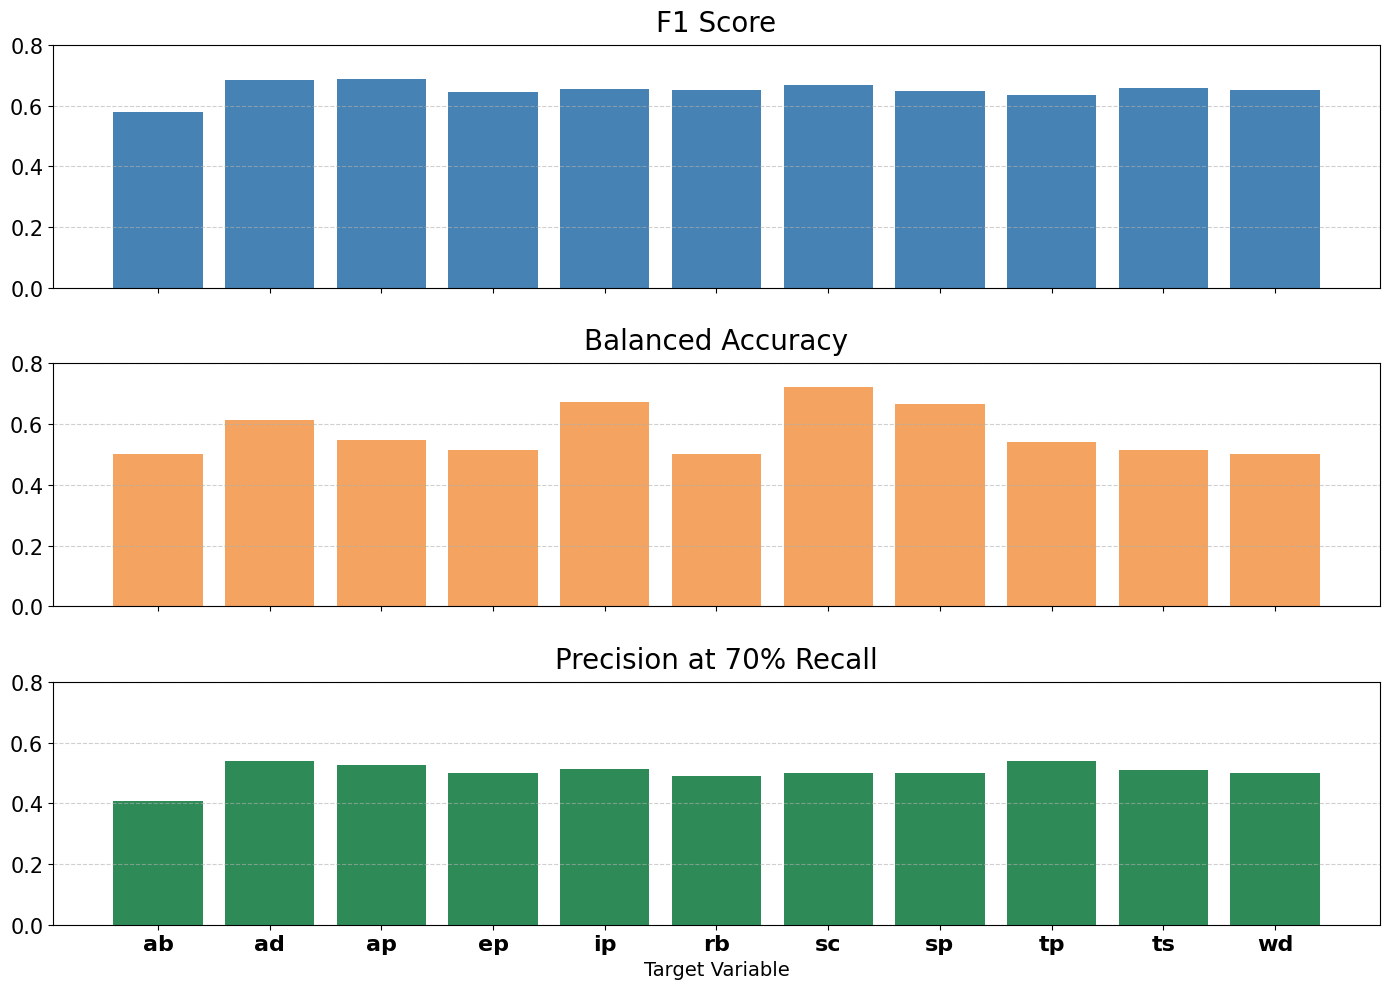

In [21]:
plot_combined_metrics(test)

In [318]:
my_df = pd.read_csv('THIS_IS_IT5050T1.csv')
my_df1 = pd.read_csv('THIS_YEAH_T0_5050.csv')

In [316]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]

    # Extract short two-letter labels (e.g., "sab" → "ab")
    short_labels = [label.split('_')[3] for label in target_order]

    # Metric configurations: (column, plot title, bar color, y-axis label)
    metrics = [
        ("F1", "F1 Score", "dodgerblue", "Score"),
        ("Balanced Accuracy", "Balanced Accuracy", "tan", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "mediumaquamarine", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=13)
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


/tmp/ipykernel_3183052/843420634.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')


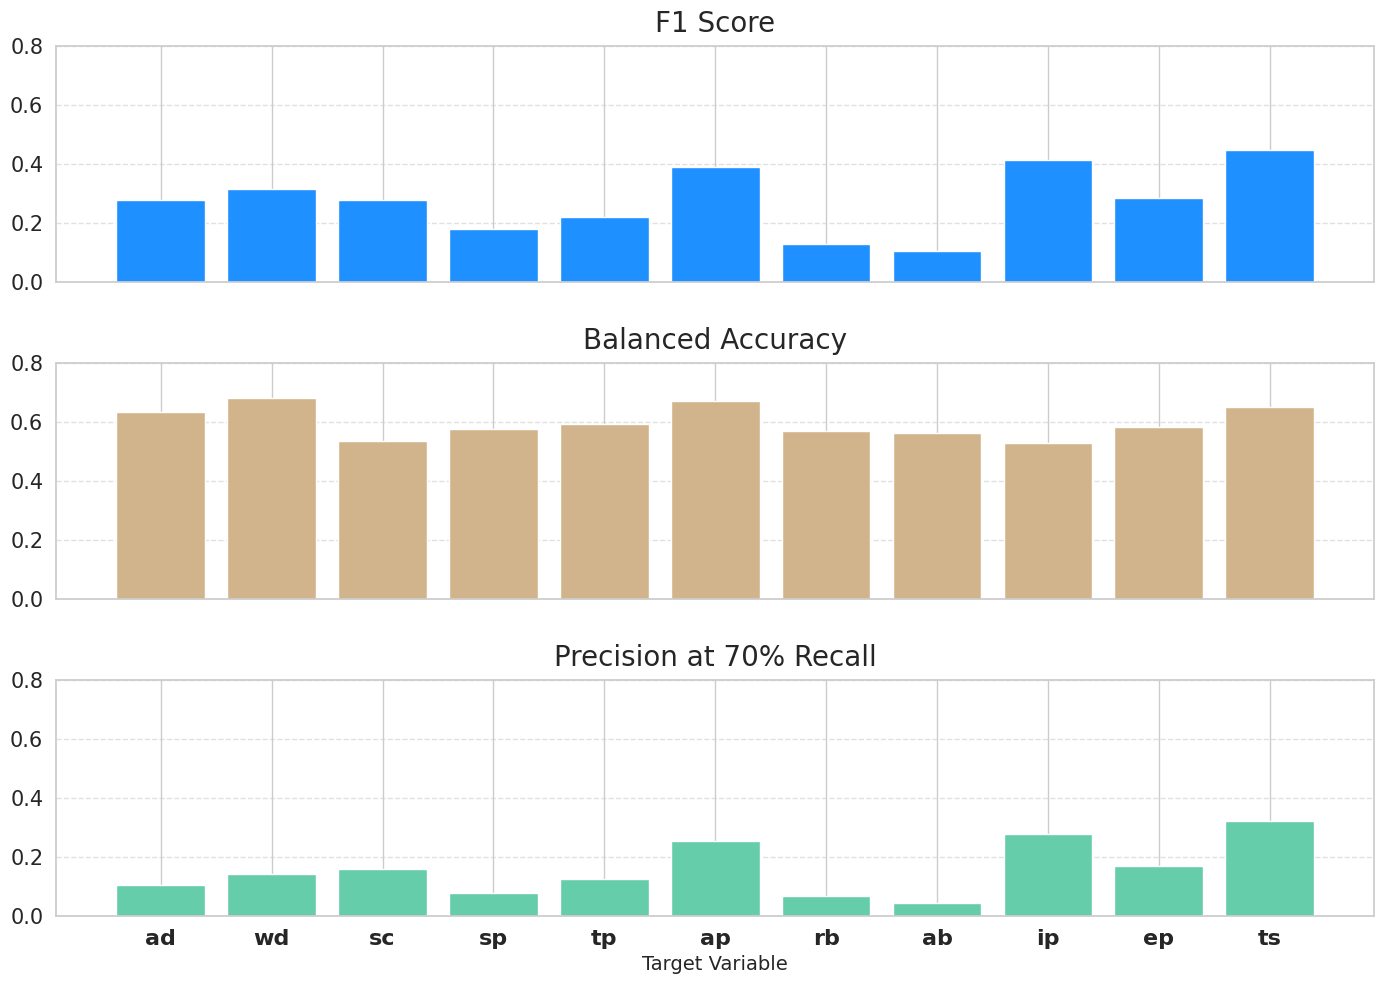

In [317]:
plot_combined_metrics(my_df)

/tmp/ipykernel_3183052/1472361758.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')


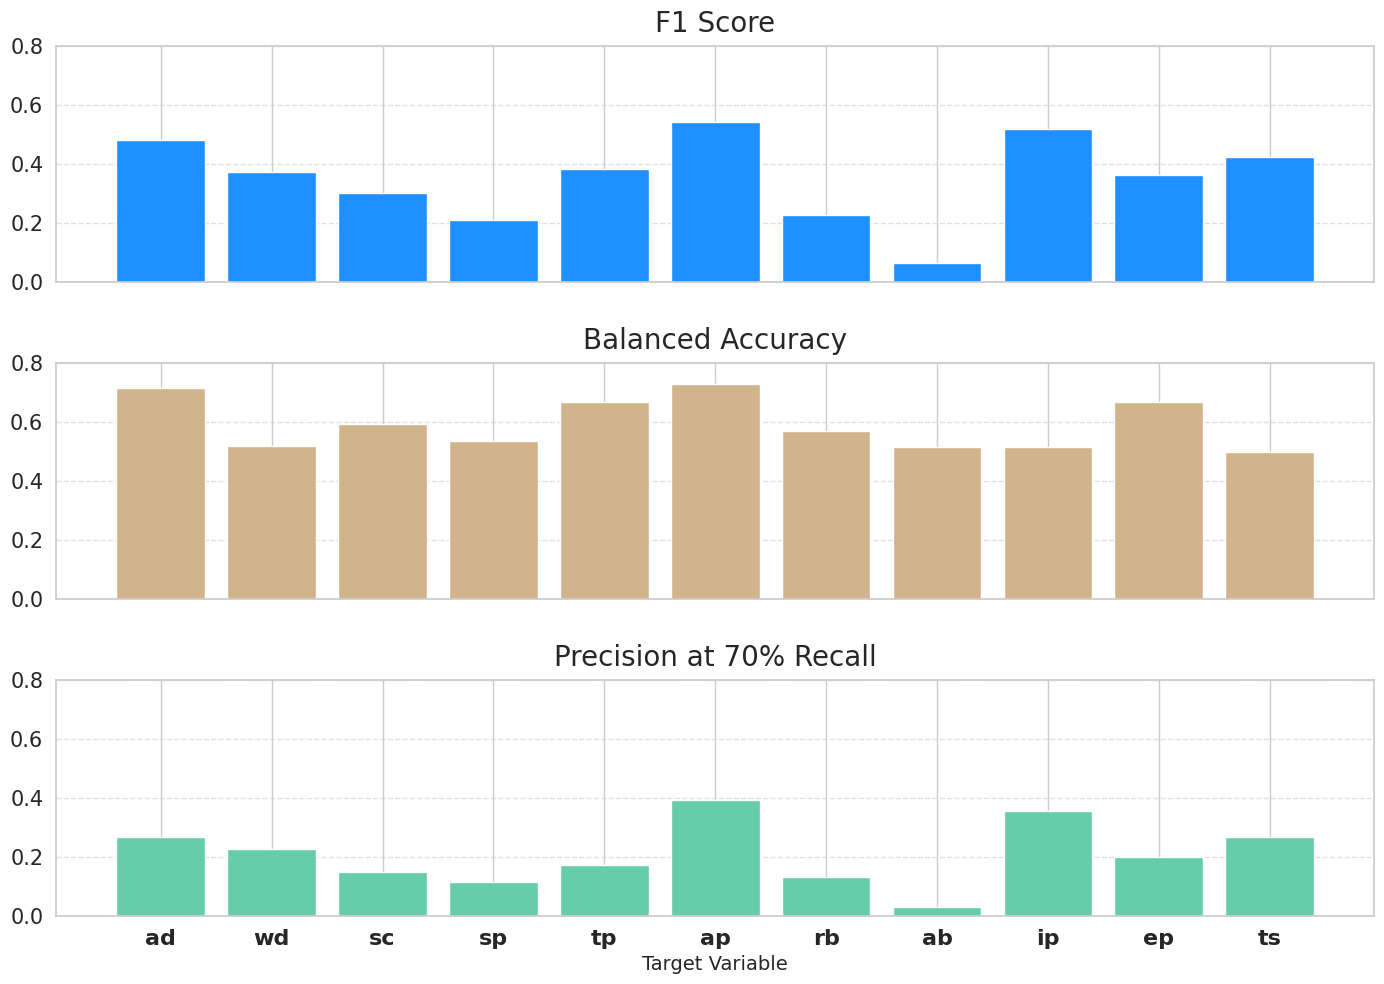

In [315]:
plot_combined_metrics(my_df1)

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_features_boxplots(df, final_results_df, target):
    # Get top 3 features for the specified target
    row = final_results_df[final_results_df["Target"] == target]
    if row.empty:
        print(f"⚠️ Target {target} not found in results.")
        return

    top_feats = [row["Top Feature 1"].values[0],
                 row["Top Feature 2"].values[0],
                 row["Top Feature 3"].values[0]]

    # Filter original dataframe to valid rows
    if target not in df.columns:
        print(f"⚠️ Target {target} not in main DataFrame.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    sns.set(style="whitegrid")

    for i, feat in enumerate(top_feats):
        ax = axes[i]
        if not feat or feat not in df.columns:
            ax.set_visible(False)
            continue

        # Adaptive outlier removal using IQR
        Q1 = df[feat].quantile(0.25)
        Q3 = df[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df = df[(df[feat] >= lower_bound) & (df[feat] <= upper_bound)]

        # Plotting
        sns.boxplot(x=target, y=feat, hue=target, data=clean_df, ax=ax,
                    palette="Set2", width=0.5, fliersize=3, legend=False)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax,
                      jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_title(feat, fontsize=11, pad=10)
        ax.set_xlabel("Label (0 = Normal, 1 = Clinical)", fontsize=10)
        ax.set_ylabel("Feature Value", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def plot_top_features_boxplots(df, final_results_df, target):
    # Get top 3 features for the specified target
    row = final_results_df[final_results_df["Target"] == target]
    if row.empty:
        print(f"⚠️ Target {target} not found in results.")
        return

    top_feats = [row["Top Feature 1"].values[0],
                 row["Top Feature 2"].values[0],
                 row["Top Feature 3"].values[0]]

    if target not in df.columns:
        print(f"⚠️ Target {target} not in main DataFrame.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    sns.set(style="whitegrid")

    for i, feat in enumerate(top_feats):
        ax = axes[i]
        if not feat or feat not in df.columns:
            ax.set_visible(False)
            continue

        # Remove extreme outliers using IQR
        Q1 = df[feat].quantile(0.25)
        Q3 = df[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df = df[(df[feat] >= lower_bound) & (df[feat] <= upper_bound)]

        # Mann–Whitney U test
        data = clean_df[[target, feat]].dropna()
        group_0 = data[data[target] == 0][feat]
        group_1 = data[data[target] == 1][feat]

        if len(group_0) >= 5 and len(group_1) >= 5:
            p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')[1]
            p_display = f"(p = {p_value:.3f})" + (" *" if p_value < 0.05 else "")
        else:
            p_display = "(p = NA)"

        title = f"{feat}\n{p_display}"

        # Plotting
        sns.boxplot(x=target, y=feat, hue=target, data=clean_df, ax=ax,
                    palette="Set2", width=0.5, fliersize=3, legend=False)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax,
                      jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


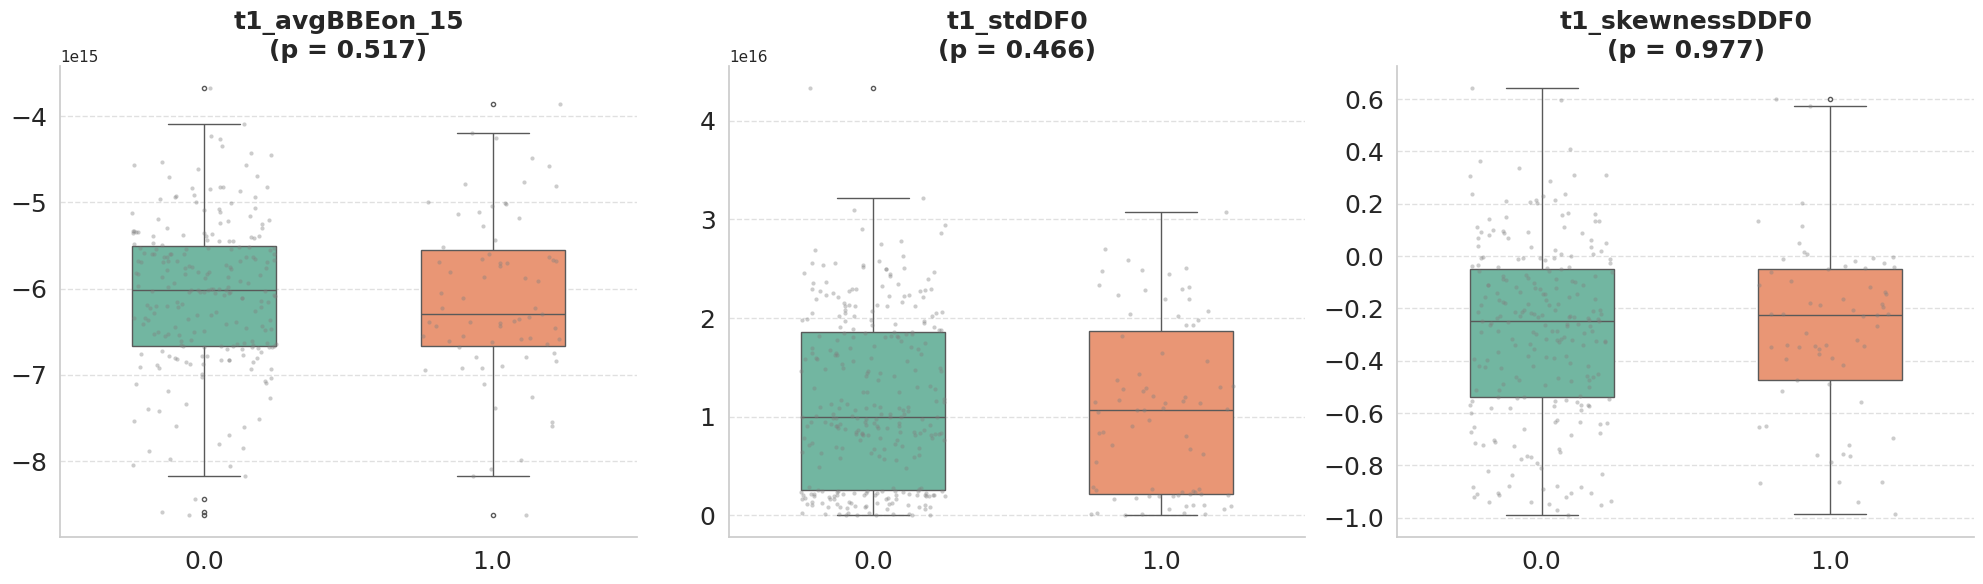

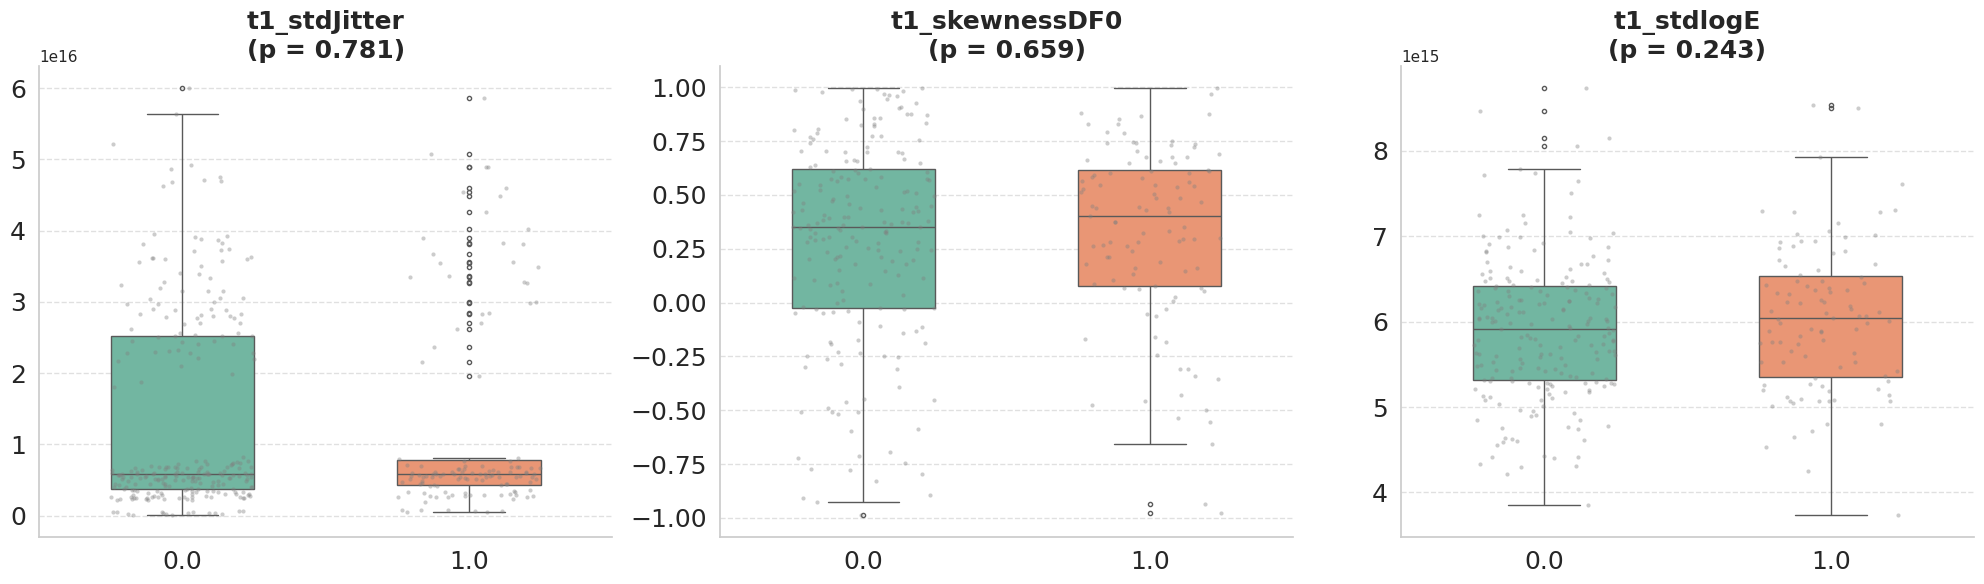

In [179]:
plot_top_features_boxplots(df, final_results_correctt1, target="T1_YSR_93_98_wd")
plot_top_features_boxplots(df, final_results_correctt1, target="T1_YSR_93_98_ip")

In [ ]:
from scipy.stats import mannwhitneyu

# Track p-values
p_values = []
significance_flags = []

for i, row in top_features_df.iterrows():
    target = row["Target"]
    feature = row["Feature"]

    if target not in df.columns or feature not in df.columns:
        p_values.append(None)
        significance_flags.append(False)
        continue

    data = df[[target, feature]].dropna()
    group_0 = data[data[target] == 0][feature]
    group_1 = data[data[target] == 1][feature]

    if len(group_0) < 5 or len(group_1) < 5:
        p_values.append(None)
        significance_flags.append(False)
        continue

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    p_values.append(p)
    significance_flags.append(p < 0.05)

# Add results to dataframe
top_features_df["P_Value"] = p_values
top_features_df["Significant"] = significance_flags

In [21]:
def extract_top_features_no_pca(df, best_models_df, models, top_n=3):
    results = []
    acoustic_features = df.columns[90:]  # Adjust if needed

    for _, row in best_models_df.iterrows():
        target = row["Target"]
        model_name = row["Model"]

        if "PCA" in model_name:
            continue  # Skip PCA models

        # Prepare data
        data = df[[target]].join(df[acoustic_features]).dropna()
        X = data[acoustic_features]
        y = data[target]

        # Fit the best model
        model = clone(models[model_name])
        model.fit(X, y)

        # Get final logistic regression step
        if hasattr(model, "named_steps"):
            logreg = model.named_steps.get("logreg")
            if logreg is None:
                continue
        else:
            continue  # Not a pipeline

        # Get feature names after kbest (if present)
        if "kbest" in model.named_steps:
            kbest = model.named_steps["kbest"]
            selected_idxs = kbest.get_support(indices=True)
            feature_names = acoustic_features[selected_idxs]
        else:
            feature_names = acoustic_features

        # Extract coefficients
        coefs = logreg.coef_[0]
        top_idx = np.argsort(np.abs(coefs))[-top_n:][::-1]
        top_features = [(feature_names[i], coefs[i]) for i in top_idx]

        for feat, weight in top_features:
            results.append({
                "Target": target,
                "Model": model_name,
                "Feature": feat,
                "Coefficient": weight
            })

    return pd.DataFrame(results)

# Example usage:
top_features_df = extract_top_features_no_pca(df, final_results_df_5050, models)
display(top_features_df)


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

,Target,Model,Feature,Coefficient
0,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_chroma_std_std,-1.432211e-15
1,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_kurtosis,-9.389837e-16
2,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltachroma_1_max,-4.692007e-16
3,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_4_max,1.377422e-12
4,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_11_max,1.043752e-12
5,T1_YSR_sep_binary,KBest - SMOTE,t1_avgDDMFCCon_11,3.582896e-14
6,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEon_9,5.768517e-16
7,T1_YSR_sip_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_max,1.577733e-16
8,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEoff_7,1.537764e-16
9,T1_YSR_srb_binary,No FS - ElasticNet,t1_kurtosisF2,-1.736790e-16


In [25]:
from scipy.stats import mannwhitneyu

# Track p-values
p_values = []
significance_flags = []

for i, row in top_features_df.iterrows():
    target = row["Target"]
    feature = row["Feature"]

    if target not in df.columns or feature not in df.columns:
        p_values.append(None)
        significance_flags.append(False)
        continue

    data = df[[target, feature]].dropna()
    group_0 = data[data[target] == 0][feature]
    group_1 = data[data[target] == 1][feature]

    if len(group_0) < 5 or len(group_1) < 5:
        p_values.append(None)
        significance_flags.append(False)
        continue

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    p_values.append(p)
    significance_flags.append(p < 0.05)

# Add results to dataframe
top_features_df["P_Value"] = p_values
top_features_df["Significant"] = significance_flags


In [26]:
top_features_df

,Target,Model,Feature,Coefficient,P_Value,P_FDR,Significant_FDR,Significant
0,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_chroma_std_std,-1.432211e-15,0.280046,0.736218,False,False
1,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_kurtosis,-9.389837e-16,0.922301,0.922301,False,False
2,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltachroma_1_max,-4.692007e-16,0.818547,0.879831,False,False
3,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_4_max,1.377422e-12,0.172794,0.736218,False,False
4,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_11_max,1.043752e-12,0.651892,0.879831,False,False
5,T1_YSR_sep_binary,KBest - SMOTE,t1_avgDDMFCCon_11,3.582896e-14,0.491925,0.879831,False,False
6,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEon_9,5.768517e-16,0.795153,0.879831,False,False
7,T1_YSR_sip_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_max,1.577733e-16,0.103366,0.736218,False,False
8,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEoff_7,1.537764e-16,0.688485,0.879831,False,False
9,T1_YSR_srb_binary,No FS - ElasticNet,t1_kurtosisF2,-1.736790e-16,0.368109,0.736218,False,False


In [29]:
def clean_feature_name(raw_name):
    """Remove prefix from feature name (e.g., 't1_paa_' → '')"""
    return "_".join(raw_name.split("_")[2:])

# Create dictionaries for each target: features and significance
feature_dict = {}
significance_dict = {}

for target in top_features_df["Target"].unique():
    sub_df = top_features_df[top_features_df["Target"] == target]
    features = [f for f in sub_df["Feature"]]
    significance = ["True" if sig else "False" for sig in sub_df["Significant"]]
    feature_dict[target] = features
    significance_dict[target] = significance

# Add to final_results_df_5050
top_features = []
feature_significance = []

for target in final_results_df_5050["Target"]:
    feats = feature_dict.get(target, [])
    sigs = significance_dict.get(target, [])
    
    if feats and sigs:
        top_features.append(", ".join(feats))
        feature_significance.append(", ".join(sigs))
    else:
        top_features.append("")
        feature_significance.append("")

final_results_df_5050["Top Features"] = top_features
final_results_df_5050["Significant"] = feature_significance


In [30]:
final_results_df_5050

,Target,Model,Accuracy,Precision,Recall,F1 (test),Balanced Accuracy (test),Threshold Used,F1 at Threshold,Precision@70%Recall,TP,TN,FP,FN,Top Features,Significant
0,T1_YSR_sab_binary,KBest - ElasticNet,0.406250,0.406250,1.000000,0.577778,0.500000,0.012673,0.577778,0.406250,26,0,38,0,"t1_paa_chroma_std_std, t1_paa_deltaspectral_ro...","False, False, False"
1,T1_YSR_sad_binary,PCA - ElasticNet,0.484375,0.476190,1.000000,0.645161,0.514706,0.005425,0.645161,0.476190,30,1,33,0,,
2,T1_YSR_sap_binary,PCA - Balanced,0.500000,0.500000,1.000000,0.666667,0.500000,0.051699,0.666667,0.500000,32,0,32,0,,
3,T1_YSR_sep_binary,KBest - SMOTE,0.468750,0.468750,1.000000,0.638298,0.500000,0.156437,0.638298,0.473684,30,0,34,0,"t1_paa_mfcc_4_max, t1_paa_mfcc_11_max, t1_avgD...","False, False, False"
4,T1_YSR_sip_binary,KBest - ElasticNet,0.484375,0.467742,1.000000,0.637363,0.528571,0.170850,0.637363,0.473684,29,2,33,0,"t1_skewnessBBEon_9, t1_paa_deltaspectral_rollo...","False, False, False"
5,T1_YSR_srb_binary,No FS - ElasticNet,0.531250,0.508197,1.000000,0.673913,0.545455,0.000814,0.673913,0.568182,31,3,30,0,"t1_kurtosisF2, t1_skewnessDDMFCCoff_12, t1_avg...","False, False, True"
6,T1_YSR_ssc_binary,PCA - SMOTE,0.406250,0.406250,1.000000,0.577778,0.500000,0.003222,0.577778,0.409836,26,0,38,0,,
7,T1_YSR_ssp_binary,KBest - ElasticNet,0.531250,0.452830,0.960000,0.615385,0.608205,0.474286,0.615385,0.461538,24,10,29,1,"t1_skewnessBBEoff_9, t1_avgDDMFCCoff_4, t1_avg...","False, False, False"
8,T1_YSR_stp_binary,PCA - Balanced,0.468750,0.460317,1.000000,0.630435,0.514286,0.036601,0.630435,0.460317,29,1,34,0,,
9,T1_YSR_sts_binary,PCA - SMOTE,0.531250,0.508475,0.967742,0.666667,0.544477,0.080457,0.666667,0.518519,30,4,29,1,,


In [24]:
top_features_df.to_csv("TOP_FEATURES_T1_5050.csv", index=False)

In [39]:
top_features_df

,Target,Model,Feature,Coefficient,P_Value,P_FDR,Significant_FDR,Significant
0,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_chroma_std_std,-1.432211e-15,0.280046,0.736218,False,False
1,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_kurtosis,-9.389837e-16,0.922301,0.922301,False,False
2,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltachroma_1_max,-4.692007e-16,0.818547,0.879831,False,False
3,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_4_max,1.377422e-12,0.172794,0.736218,False,False
4,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_11_max,1.043752e-12,0.651892,0.879831,False,False
5,T1_YSR_sep_binary,KBest - SMOTE,t1_avgDDMFCCon_11,3.582896e-14,0.491925,0.879831,False,False
6,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEon_9,5.768517e-16,0.795153,0.879831,False,False
7,T1_YSR_sip_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_max,1.577733e-16,0.103366,0.736218,False,False
8,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEoff_7,1.537764e-16,0.688485,0.879831,False,False
9,T1_YSR_srb_binary,No FS - ElasticNet,t1_kurtosisF2,-1.736790e-16,0.368109,0.736218,False,False


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def clean_feature_name(raw_name):
    return "_".join(raw_name.split("_")[2:]) if "_" in raw_name else raw_name

def plot_top3_boxplots(df, top_features_df, target):
    sns.set(style="whitegrid")

    # Get top features for the given target
    target_feats = top_features_df[top_features_df["Target"] == target]
    
    if target_feats.empty:
        print(f"⚠️ No features found for target {target}")
        return

    top3_feats = target_feats["Feature"].head(3).tolist()
    top3_feats_clean = [clean_feature_name(f) for f in top3_feats]

    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

    for i, feat in enumerate(top3_feats_clean):
        if feat not in df.columns:
            print(f"⚠️ Feature {feat} not found in data.")
            continue

        # Remove extreme outliers robustly
        q_low, q_high = df[feat].quantile([0.05, 0.95])
        clean_df = df[(df[feat] >= q_low) & (df[feat] <= q_high)]

        # Additional hard cap
        if clean_df[feat].max() > 1e6:
            clean_df = clean_df[clean_df[feat] < 1e6]

        ax = axes[i]
        sns.boxplot(x=target, y=feat, data=clean_df, ax=ax, width=0.5, palette="Set2", fliersize=3)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax, jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_xlabel("Label (0 = Normal, 1 = Clinical)", fontsize=10)
        ax.set_ylabel(feat, fontsize=10)
        ax.set_title(f"Feature: {feat}", fontsize=11, pad=10)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        sns.despine(ax=ax, trim=True)

    plt.suptitle(f"Top 3 Predictive Features for {target}", fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

⚠️ Feature  not found in data.
⚠️ Feature 12 not found in data.
⚠️ Feature 11 not found in data.


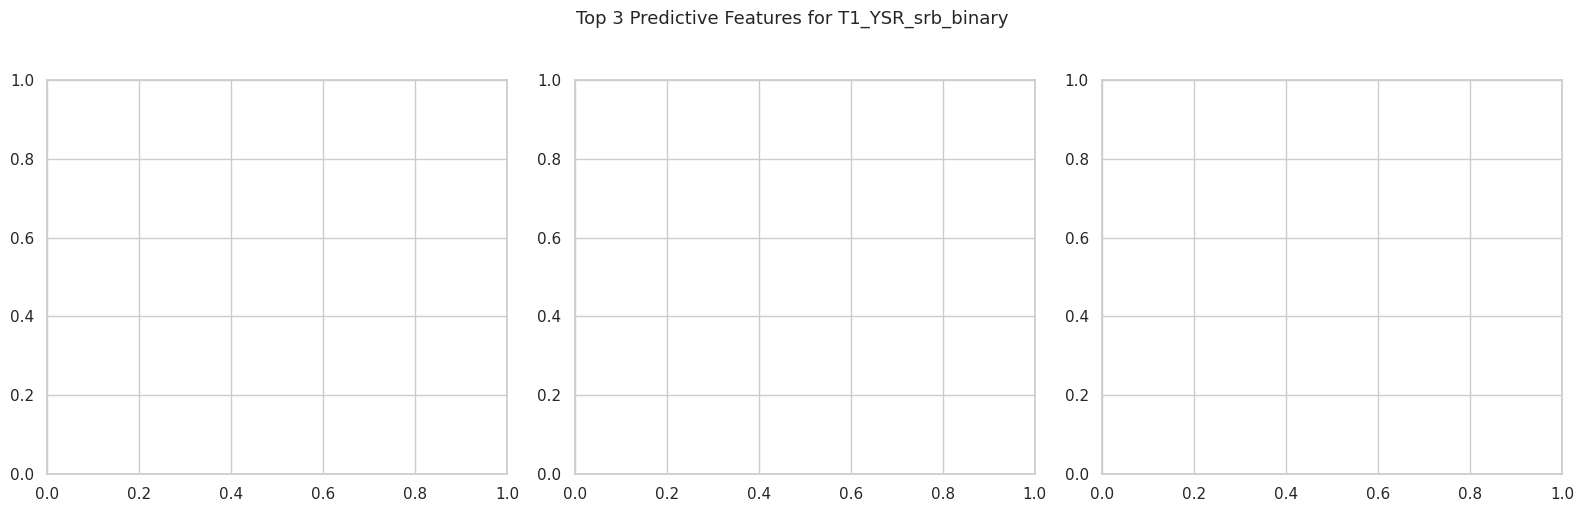

In [38]:
plot_top3_boxplots(df, top_features_df, target="T1_YSR_srb_binary")

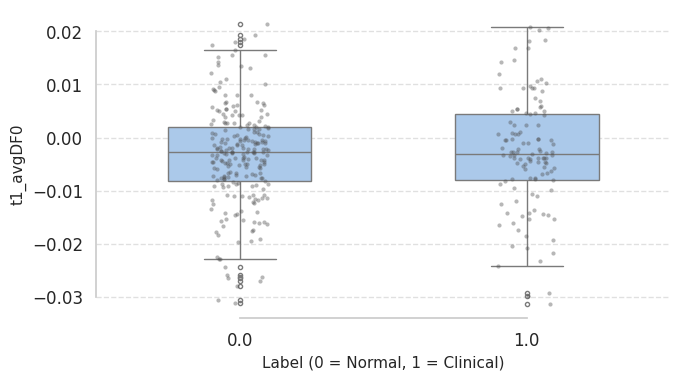

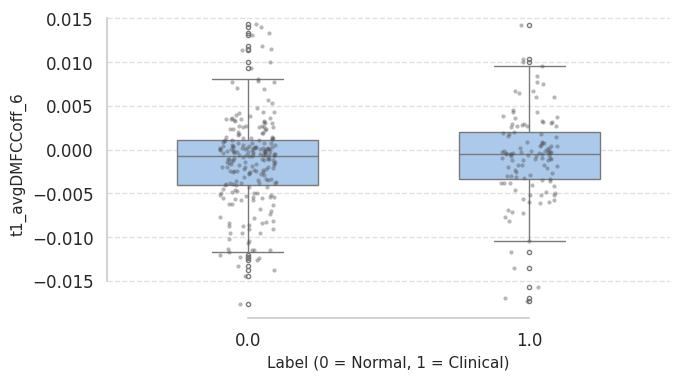

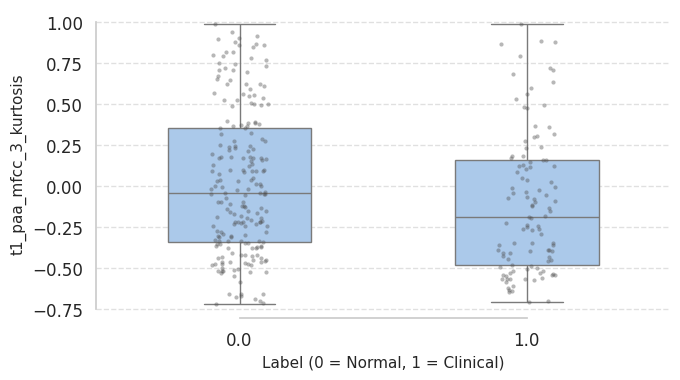

In [109]:
import seaborn as sns

for feat in top3:
    if feat not in df.columns:
        print(f"⚠️ Feature {feat} not found.")
        continue

    # Remove extreme outliers robustly
    q_low, q_high = df[feat].quantile([0.05, 0.95])
    clean_df = df[(df[feat] >= q_low) & (df[feat] <= q_high)]

    # Optional hard cap if still crazy
    if clean_df[feat].max() > 1e6:
        clean_df = clean_df[clean_df[feat] < 1e6]

    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x=target, y=feat, data=clean_df, width=0.5, fliersize=3)
    sns.stripplot(x=target, y=feat, data=clean_df, jitter=True, size=3, color=".3", alpha=0.4)
    ax.set_xlabel("Label (0 = Normal, 1 = Clinical)", fontsize=11)
    ax.set_ylabel(feat, fontsize=11)
    sns.despine(trim=True)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [110]:
from scipy.stats import mannwhitneyu

for feat in top3:
    if feat not in df.columns:
        continue

    # Drop NaNs
    feature_values = df[[target, feat]].dropna()

    group_0 = feature_values[feature_values[target] == 0][feat]
    group_1 = feature_values[feature_values[target] == 1][feat]

    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

    print(f"Feature: {feat}")
    print(f"  Mann–Whitney U p-value: {p_value:.4f}")
    print("  Significant!" if p_value < 0.05 else "  Not significant.")
    print()


Feature: t1_avgDF0
  Mann–Whitney U p-value: 0.7564
  Not significant.

Feature: t1_avgDMFCCoff_6
  Mann–Whitney U p-value: 0.3397
  Not significant.

Feature: t1_paa_mfcc_3_kurtosis
  Mann–Whitney U p-value: 0.0343
  Significant!



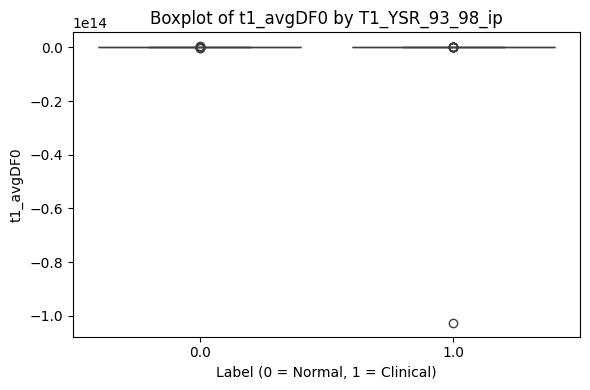

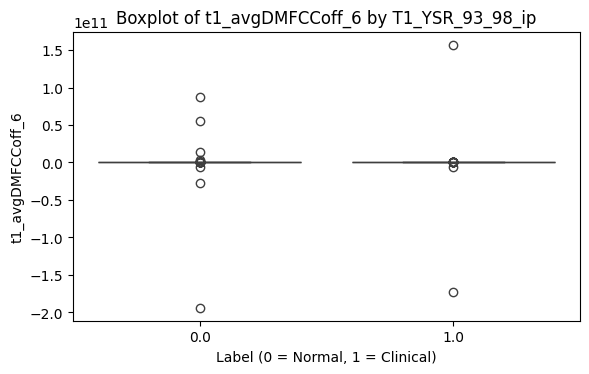

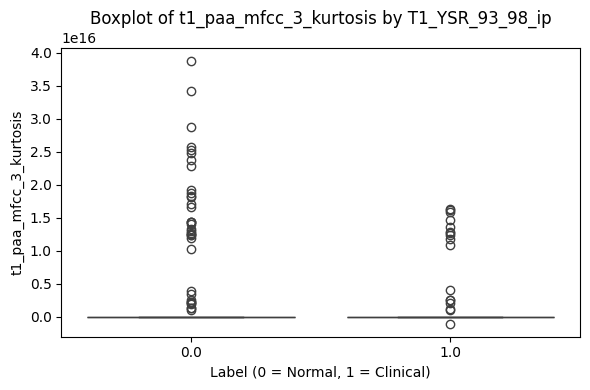

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter top features for this label
target = "T1_YSR_93_98_ip"
top3 = top_features_df[top_features_df["Target"] == target].nlargest(3, "Coefficient")["Feature"].tolist()

# Plot boxplots
for feature in top3:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f"Boxplot of {feature} by {target}")
    plt.xlabel("Label (0 = Normal, 1 = Clinical)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


In [67]:
final_results_df.to_csv("TEST_T1_all_models.csv", index=False)

In [ ]:
for target in tqdm(target_columns):
    data = df[[target]].join(df[df.columns[79:]]).dropna()
    y = data[target]
    X = data[df.columns[79:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]

           # ----- Precision-Recall Curve -----
            precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

            # Compute F1 score for each threshold
            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

            # Only keep thresholds with sufficient precision AND recall
            min_precision = 0.3
            min_recall = 0.3

            valid_idxs = [
                i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1]))  # match len(thresholds)
                if p >= min_precision and r >= min_recall
            ]

            if valid_idxs:
                best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
                threshold = thresholds[best_f1_idx]
                best_f1 = f1_scores[best_f1_idx]
            else:
                print(f"⚠️ {model_name}: No threshold met precision ≥ {min_precision} and recall ≥ {min_recall}.")
                threshold = 0.5  # fallback
                best_f1 = np.nan



            print(f"Model: {model_name}")
            print(f"  Selected threshold for max F1: {threshold:.4f}")
            print(f"  Max F1 at threshold: {best_f1:.4f}")
            print(f"  y_proba sample: {np.round(y_proba[:5], 4)}")

            # Predict using selected threshold
            y_pred = (y_proba >= threshold).astype(int)
            prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
            recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

            # Define precision@70%recall (at chosen threshold only)
            precision_at_70recall = prec_at_thresh if recall_at_thresh >= 0.7 else np.nan

            # Test set metrics
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Cross-validation
            stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            cv_scores = cross_validate(
                clone(model),
                X, y,
                scoring=scoring,
                cv=stratified_cv,
                return_train_score=False,
                error_score='raise',
                n_jobs=10
            )

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": np.mean(cv_scores['test_roc_auc']),
                "ROC AUC Std": np.std(cv_scores['test_roc_auc']),
                "PR AUC Mean": np.mean(cv_scores['test_pr_auc']),
                "PR AUC Std": np.std(cv_scores['test_pr_auc']),
                "F1 Mean": np.mean(cv_scores['test_f1']),
                "F1 Std": np.std(cv_scores['test_f1']),
                "Balanced Accuracy Mean": np.mean(cv_scores['test_balanced_accuracy']),
                "Balanced Accuracy Std": np.std(cv_scores['test_balanced_accuracy']),
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1 (test)": f1,
                "Balanced Accuracy (test)": bal_acc,
                "Precision@70%Recall": precision_at_70recall,
                "Threshold Used": threshold,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            print(f"Model {model_name} failed on target {target} with error: {e}")

results_df = pd.DataFrame(results)
results_df.to_csv("12vars_STRATIFIED_CV_THRESHOLDING_FINAL.csv", index=False)


In [ ]:
target_columns=[
    'T1_YSR_sad_bin',
    'T1_YSR_swd_bin',
    'T1_YSR_ssc_bin',
    'T1_YSR_ssp_bin',
    'T1_YSR_stp_bin',
    'T1_YSR_sap_bin',
    'T1_YSR_srb_bin',
    'T1_YSR_sab_bin',
    'T1_YSR_sip_bin',
    'T1_YSR_sep_bin',
    'T1_YSR_sts_bin'
]

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)
results = []

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

for target in tqdm(target_columns):
    data = df[[target]].join(df[df.columns[91:]]).dropna()
    y = data[target]
    X = data[df.columns[91:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "No FS - SMOTE + L1": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - SMOTE + L1": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - SMOTE + L1": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
    }

    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
            idx = np.argmax(recalls >= 0.70)
            precision_at_70recall = precisions[idx] if idx < len(precisions) else np.nan

            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            cv_scores = cross_validate(
                model, X, y,
                scoring=scoring, cv=5, return_train_score=False, error_score='raise'
            )

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": np.mean(cv_scores['test_roc_auc']),
                "ROC AUC Std": np.std(cv_scores['test_roc_auc']),
                "PR AUC Mean": np.mean(cv_scores['test_pr_auc']),
                "PR AUC Std": np.std(cv_scores['test_pr_auc']),
                "F1 Mean": np.mean(cv_scores['test_f1']),
                "F1 Std": np.std(cv_scores['test_f1']),
                "Balanced Accuracy Mean": np.mean(cv_scores['test_balanced_accuracy']),
                "Balanced Accuracy Std": np.std(cv_scores['test_balanced_accuracy']),
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1 (test)": f1,
                "Balanced Accuracy (test)": bal_acc,
                "Precision@70%Recall": precision_at_70recall,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": None,
                "ROC AUC Std": None,
                "PR AUC Mean": None,
                "PR AUC Std": None,
                "F1 Mean": None,
                "F1 Std": None,
                "Balanced Accuracy Mean": None,
                "Balanced Accuracy Std": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1 (test)": None,
                "Balanced Accuracy (test)": None,
                "Precision@70%Recall": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

results_df = pd.DataFrame(results)
results_df.to_csv("12vars_CV_5050.csv", index=False)


# NO FEATURE SELECTION/DIM REDUCTION

In [13]:
###removing constant features
###using robust scaler as it is resistant to outliers
#####this is a shared pre processing pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold

preprocessor = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler())
])

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Pipeline with preprocessing + logistic regression
pipe_balanced = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Fit model
pipe_balanced.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        54
           1       0.11      0.20      0.14        10

    accuracy                           0.62        64
   macro avg       0.47      0.45      0.45        64
weighted avg       0.71      0.62      0.66        64

ROC AUC: 0.32222222222222224


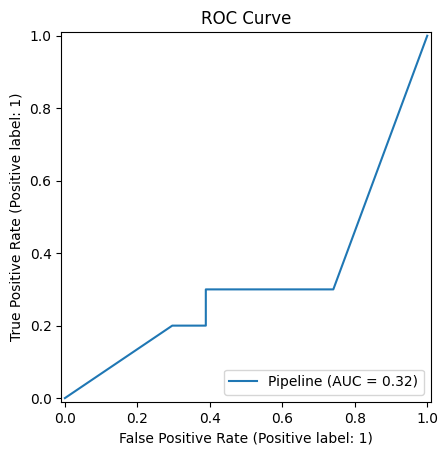

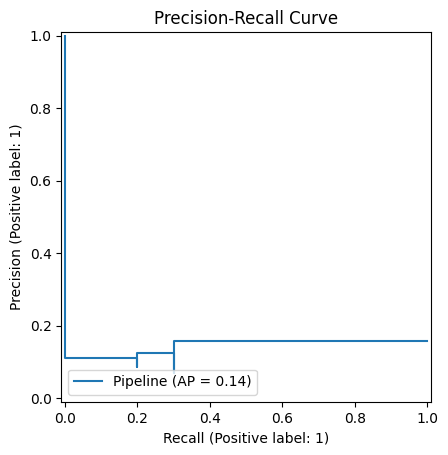

In [15]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# ROC Curve
RocCurveDisplay.from_estimator(pipe_balanced, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# PR Curve
PrecisionRecallDisplay.from_estimator(pipe_balanced, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

In [18]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)
y_proba_smote = pipe_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression")
print(classification_report(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))

SMOTE + Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        54
           1       0.10      0.20      0.13        10

    accuracy                           0.59        64
   macro avg       0.46      0.43      0.43        64
weighted avg       0.71      0.59      0.64        64

ROC AUC: 0.43333333333333335


In [19]:
from sklearn.linear_model import LogisticRegressionCV

pipe_l1 = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_l1.fit(X_train, y_train)
y_pred_l1 = pipe_l1.predict(X_test)
y_proba_l1 = pipe_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression")
print(classification_report(y_test, y_pred_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_l1))


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        54
           1       0.07      0.10      0.08        10

    accuracy                           0.64        64
   macro avg       0.44      0.42      0.43        64
weighted avg       0.70      0.64      0.67        64

ROC AUC: 0.40740740740740744


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


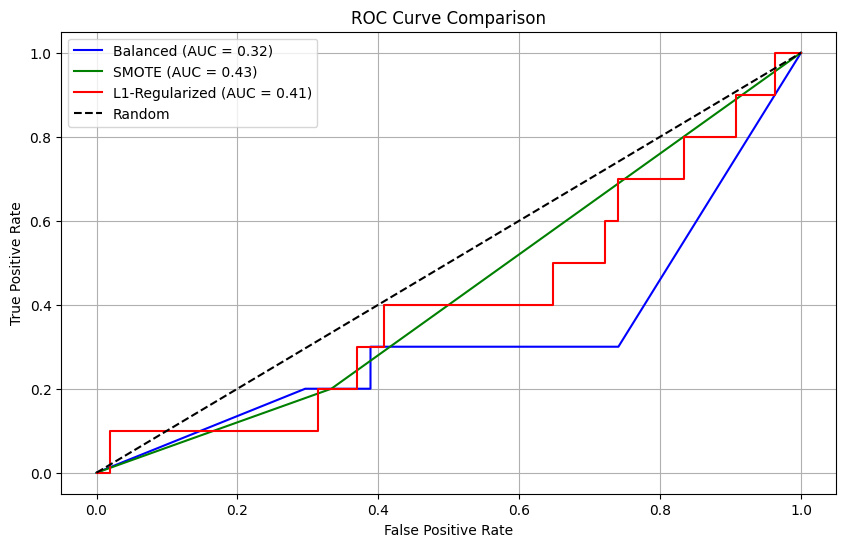

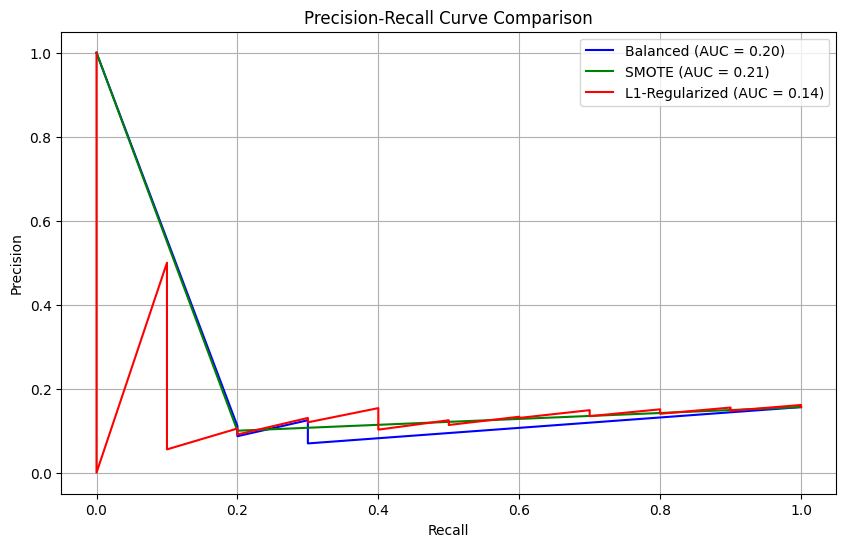

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Store model outputs
model_names = ['Balanced', 'SMOTE', 'L1-Regularized']
y_probs = [y_proba, y_proba_smote, y_proba_l1]
y_preds = [y_pred, y_pred_smote, y_pred_l1]
colors = ['blue', 'green', 'red']

# ROC Curve comparison
plt.figure(figsize=(6,4))
for name, prob, color in zip(model_names, y_probs, colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve comparison
plt.figure(figsize=(6,4))
for name, prob, color in zip(model_names, y_probs, colors):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})', color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


# FEATURE SELECTION BY SELECT K BEST

In [46]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Choose top k acoustic features
k = 100  # Try different values like 50, 100, 200...

feature_selector = SelectKBest(score_func=mutual_info_classif, k=k)

preprocessor_kbest = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('select', feature_selector)
])

In [47]:
### balanced logistic regression

from sklearn.linear_model import LogisticRegression

pipe_kbest_balanced = Pipeline([
    ('preprocessing', preprocessor_kbest),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

pipe_kbest_balanced.fit(X_train, y_train)
y_pred_kbest_balanced = pipe_kbest_balanced.predict(X_test)
y_proba_kbest_balanced = pipe_kbest_balanced.predict_proba(X_test)[:, 1]

print("Balanced Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_balanced))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_balanced))


Balanced Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.89      0.46      0.61        54
           1       0.19      0.70      0.30        10

    accuracy                           0.50        64
   macro avg       0.54      0.58      0.46        64
weighted avg       0.78      0.50      0.56        64

ROC AUC: 0.525


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
### smote

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe_kbest_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_kbest_smote.fit(X_train, y_train)
y_pred_kbest_smote = pipe_kbest_smote.predict(X_test)
y_proba_kbest_smote = pipe_kbest_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_smote))


SMOTE + Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.82      0.52      0.64        54
           1       0.13      0.40      0.20        10

    accuracy                           0.50        64
   macro avg       0.48      0.46      0.42        64
weighted avg       0.72      0.50      0.57        64

ROC AUC: 0.46296296296296297


In [49]:
### L1

from sklearn.linear_model import LogisticRegressionCV

pipe_kbest_l1 = Pipeline([
    ('preprocessing', preprocessor_kbest),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_kbest_l1.fit(X_train, y_train)
y_pred_kbest_l1 = pipe_kbest_l1.predict(X_test)
y_proba_kbest_l1 = pipe_kbest_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_l1))


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.86      0.70      0.78        54
           1       0.20      0.40      0.27        10

    accuracy                           0.66        64
   macro avg       0.53      0.55      0.52        64
weighted avg       0.76      0.66      0.70        64

ROC AUC: 0.6620370370370371


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


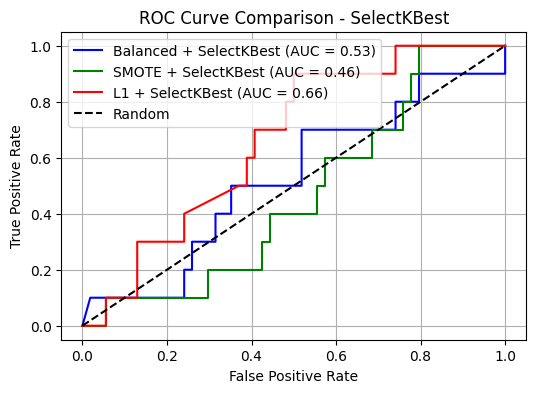

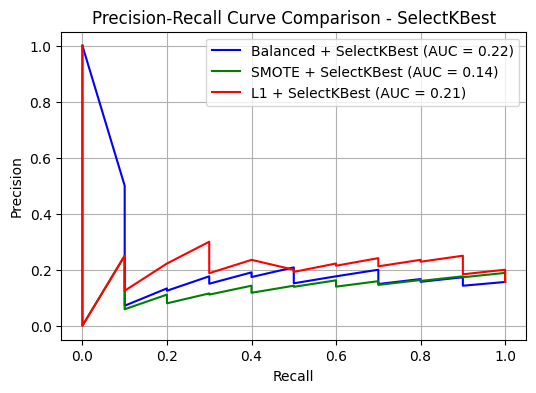

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# SelectKBest comparison
kbest_names = ['Balanced + SelectKBest', 'SMOTE + SelectKBest', 'L1 + SelectKBest']
kbest_probs = [y_proba_kbest_balanced, y_proba_kbest_smote, y_proba_kbest_l1]
kbest_colors = ['blue', 'green', 'red']

# ROC Curve
plt.figure(figsize=(6, 4))
for name, prob, color in zip(kbest_names, kbest_probs, kbest_colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - SelectKBest')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure(figsize=(6, 4))
for name, prob, color in zip(kbest_names, kbest_probs, kbest_colors):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})', color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison - SelectKBest')
plt.legend()
plt.grid(True)
plt.show()


# PCA Dimensionality Reduction

In [51]:
from sklearn.decomposition import PCA

n_components = 50  # Try 20, 50, 100
preprocessor_pca = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=n_components))
])


In [52]:
###balanced class weight

pipe_pca_balanced = Pipeline([
    ('preprocessing', preprocessor_pca),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

pipe_pca_balanced.fit(X_train, y_train)
y_pred_pca_balanced = pipe_pca_balanced.predict(X_test)
y_proba_pca_balanced = pipe_pca_balanced.predict_proba(X_test)[:, 1]

print("Balanced Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_balanced))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_balanced))


Balanced Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.86      0.56      0.67        54
           1       0.17      0.50      0.26        10

    accuracy                           0.55        64
   macro avg       0.51      0.53      0.47        64
weighted avg       0.75      0.55      0.61        64

ROC AUC: 0.5648148148148149


In [53]:
### smote

pipe_pca_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=n_components)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_pca_smote.fit(X_train, y_train)
y_pred_pca_smote = pipe_pca_smote.predict(X_test)
y_proba_pca_smote = pipe_pca_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_smote))


SMOTE + Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        54
           1       0.19      0.60      0.29        10

    accuracy                           0.55        64
   macro avg       0.54      0.57      0.48        64
weighted avg       0.77      0.55      0.61        64

ROC AUC: 0.5944444444444446


In [54]:
##### L1
pipe_pca_l1 = Pipeline([
    ('preprocessing', preprocessor_pca),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_pca_l1.fit(X_train, y_train)
y_pred_pca_l1 = pipe_pca_l1.predict(X_test)
y_proba_pca_l1 = pipe_pca_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_l1))


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.85      0.54      0.66        54
           1       0.17      0.50      0.25        10

    accuracy                           0.53        64
   macro avg       0.51      0.52      0.45        64
weighted avg       0.75      0.53      0.60        64

ROC AUC: 0.5666666666666668


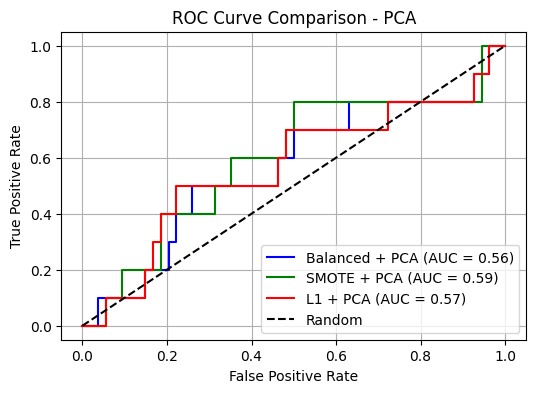

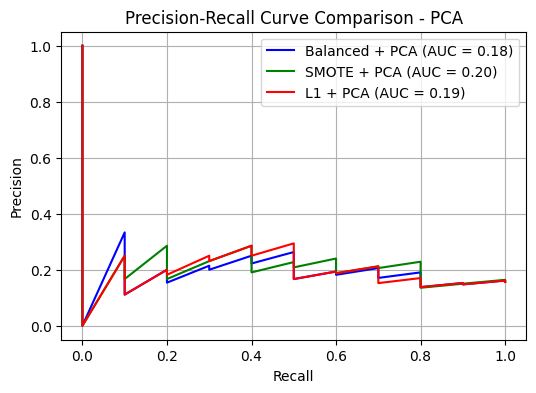

In [56]:
# PCA comparison
pca_names = ['Balanced + PCA', 'SMOTE + PCA', 'L1 + PCA']
pca_probs = [y_proba_pca_balanced, y_proba_pca_smote, y_proba_pca_l1]
pca_colors = ['blue', 'green', 'red']

# ROC Curve
plt.figure(figsize=(6,4))
for name, prob, color in zip(pca_names, pca_probs, pca_colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - PCA')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure(figsize=(6,4))
for name, prob, color in zip(pca_names, pca_probs, pca_colors):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})', color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison - PCA')
plt.legend()
plt.grid(True)
plt.show()


# compare all results

In [58]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "No FS - Balanced", "No FS - SMOTE", "No FS - L1",
        "KBest - Balanced", "KBest - SMOTE", "KBest - L1",
        "PCA - Balanced", "PCA - SMOTE", "PCA - L1"
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba),               # from no FS balanced
        roc_auc_score(y_test, y_proba_smote),         # from no FS SMOTE
        roc_auc_score(y_test, y_proba_l1),            # from no FS L1
        roc_auc_score(y_test, y_proba_kbest_balanced),
        roc_auc_score(y_test, y_proba_kbest_smote),
        roc_auc_score(y_test, y_proba_kbest_l1),
        roc_auc_score(y_test, y_proba_pca_balanced),
        roc_auc_score(y_test, y_proba_pca_smote),
        roc_auc_score(y_test, y_proba_pca_l1),
    ]
    # Optional: add PR AUCs or F1-scores too!
})

results.sort_values(by="ROC AUC", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results


,Model,ROC AUC
0,KBest - L1,0.662037
1,PCA - SMOTE,0.594444
2,PCA - L1,0.566667
3,PCA - Balanced,0.564815
4,KBest - Balanced,0.525000
5,KBest - SMOTE,0.462963
6,No FS - SMOTE,0.433333
7,No FS - L1,0.407407
8,No FS - Balanced,0.322222


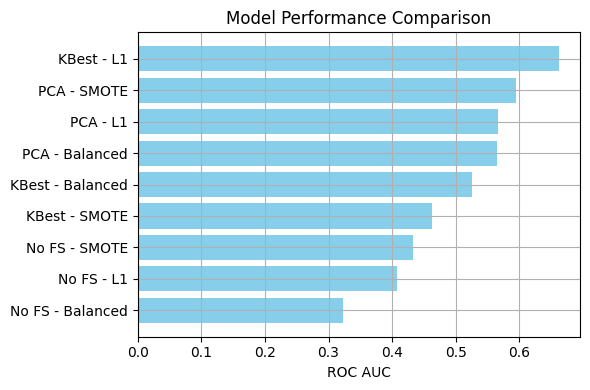

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(results['Model'], results['ROC AUC'], color='skyblue')
plt.xlabel("ROC AUC")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
###cross validation

models = {
    "No FS - Balanced": pipe_balanced,
    "No FS - SMOTE": pipe_smote,
    "No FS - L1": pipe_l1,
    "KBest - Balanced": pipe_kbest_balanced,
    "KBest - SMOTE": pipe_kbest_smote,
    "KBest - L1": pipe_kbest_l1,
    "PCA - Balanced": pipe_pca_balanced,
    "PCA - SMOTE": pipe_pca_smote,
    "PCA - L1": pipe_pca_l1
}

from sklearn.model_selection import cross_val_score

cv_results = []

for name, model in models.items():
    try:
        scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        cv_results.append({
            "Model": name,
            "Mean ROC AUC": scores.mean(),
            "Std ROC AUC": scores.std()
        })
    except Exception as e:
        cv_results.append({
            "Model": name,
            "Mean ROC AUC": None,
            "Std ROC AUC": None,
            "Error": str(e)
        })


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [63]:
cv_results

[{'Model': 'No FS - Balanced',
  'Mean ROC AUC': 0.44881201956673655,
  'Std ROC AUC': 0.07429359768579759},
 {'Model': 'No FS - SMOTE',
  'Mean ROC AUC': 0.43922431865828093,
  'Std ROC AUC': 0.07445412832717443},
 {'Model': 'No FS - L1',
  'Mean ROC AUC': 0.4597973445143257,
  'Std ROC AUC': 0.06460612021061786},
 {'Model': 'KBest - Balanced',
  'Mean ROC AUC': 0.5727044025157232,
  'Std ROC AUC': 0.05965030663828403},
 {'Model': 'KBest - SMOTE',
  'Mean ROC AUC': 0.499916142557652,
  'Std ROC AUC': 0.07360937527625082},
 {'Model': 'KBest - L1',
  'Mean ROC AUC': 0.5907407407407408,
  'Std ROC AUC': 0.10160617184032933},
 {'Model': 'PCA - Balanced',
  'Mean ROC AUC': 0.48740740740740734,
  'Std ROC AUC': 0.041787752776093215},
 {'Model': 'PCA - SMOTE',
  'Mean ROC AUC': 0.537120894479385,
  'Std ROC AUC': 0.04857063571294564},
 {'Model': 'PCA - L1',
  'Mean ROC AUC': 0.49787561146051706,
  'Std ROC AUC': 0.04503817389338452}]

# automate this process for all other target variables

In [64]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from tqdm import tqdm

results = []

for target in tqdm(target_columns):
    # Step 1: Filter NaNs
    data = df[[target]].join(df[df.columns[79:]]).dropna()
    y = data[target]
    X = data[df.columns[79:]]
    
    # Step 2: Base preprocessing blocks
    var_thresh = VarianceThreshold(threshold=0.0)
    scaler = RobustScaler()
    kbest = SelectKBest(score_func=mutual_info_classif, k=100)
    pca = PCA(n_components=50)

    # Step 3: Build 9 models
    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
    }

    # Step 4: Cross-validate each model
    for model_name, model in models.items():
        try:
            scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
            results.append({
                "Target": target,
                "Model": model_name,
                "Mean ROC AUC": scores.mean(),
                "Std ROC AUC": scores.std()
            })
        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "Mean ROC AUC": None,
                "Std ROC AUC": None,
                "Error": str(e)
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("logistic_regression_cv_results.csv", index=False)
results_df.sort_values(by=["Target", "Mean ROC AUC"], ascending=[True, False])


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

,Target,Model,Mean ROC AUC,Std ROC AUC
68,T1_YSR_93_98_ab,KBest - L1,0.580328,0.203662
67,T1_YSR_93_98_ab,KBest - SMOTE,0.575410,0.247883
66,T1_YSR_93_98_ab,KBest - Balanced,0.531148,0.211177
63,T1_YSR_93_98_ab,No FS - Balanced,0.495082,0.157974
64,T1_YSR_93_98_ab,No FS - SMOTE,0.486885,0.180149
...,...,...,...,...
10,T1_YSR_93_98_wd,No FS - SMOTE,0.436583,0.074493
11,T1_YSR_93_98_wd,No FS - L1,0.432744,0.069898
15,T1_YSR_93_98_wd,PCA - Balanced,0.429361,0.037414
9,T1_YSR_93_98_wd,No FS - Balanced,0.428140,0.078752


In [66]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

results = []

for target in tqdm(target_columns):
    # Step 1: Filter rows with NaNs
    data = df[[target]].join(df[df.columns[79:]]).dropna()
    y = data[target]
    X = data[df.columns[79:]]

    # Step 2: Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Shared preprocessors
    var_thresh = VarianceThreshold(threshold=0.0)
    scaler = RobustScaler()
    kbest = SelectKBest(score_func=mutual_info_classif, k=100)
    pca = PCA(n_components=50)

    # Step 4: Define 9 model variants
    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
    }

    # Step 5: Fit + Evaluate each model
    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            # Evaluation metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            pr_auc = average_precision_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "PR AUC": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

# Save final results
results_df_complete = pd.DataFrame(results)
results_df_complete.to_csv("logistic_regression_metrics_all_targets_T1.csv", index=False)

# Optional: display top models per target
display(results_df_complete.sort_values(by=["Target", "ROC AUC"], ascending=[True, False]))


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

,Target,Model,ROC AUC,PR AUC,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
68,T1_YSR_93_98_ab,KBest - L1,0.803279,0.108333,0.619048,0.076923,1.000000,0.142857,2,37,24,0
64,T1_YSR_93_98_ab,No FS - SMOTE,0.467213,0.043156,0.809524,0.000000,0.000000,0.000000,0,51,10,2
69,T1_YSR_93_98_ab,PCA - Balanced,0.426230,0.041739,0.492063,0.031250,0.500000,0.058824,1,30,31,1
65,T1_YSR_93_98_ab,No FS - L1,0.418033,0.040205,0.841270,0.000000,0.000000,0.000000,0,53,8,2
66,T1_YSR_93_98_ab,KBest - Balanced,0.418033,0.045285,0.507937,0.032258,0.500000,0.060606,1,31,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10,T1_YSR_93_98_wd,No FS - SMOTE,0.586735,0.270202,0.650794,0.318182,0.500000,0.388889,7,34,15,7
9,T1_YSR_93_98_wd,No FS - Balanced,0.576531,0.256944,0.619048,0.291667,0.500000,0.368421,7,32,17,7
15,T1_YSR_93_98_wd,PCA - Balanced,0.569971,0.370151,0.619048,0.272727,0.428571,0.333333,6,33,16,8
13,T1_YSR_93_98_wd,KBest - SMOTE,0.553936,0.257981,0.555556,0.266667,0.571429,0.363636,8,27,22,6


,Target,Model,ROC AUC,PR AUC,F1
0,T1_YSR_93_98_ab,KBest - L1,0.803279,0.108333,0.142857
1,T1_YSR_93_98_ts,No FS - L1,0.704604,0.497287,0.448980
2,T1_YSR_93_98_rb,KBest - Balanced,0.686224,0.189360,0.312500
3,T1_YSR_93_98_tp,No FS - L1,0.681818,0.264738,0.285714
4,T1_YSR_93_98_ep,No FS - SMOTE,0.654321,0.248020,0.347826
5,T1_YSR_93_98_wd,PCA - SMOTE,0.622449,0.361519,0.358974
6,T1_YSR_93_98_ip,PCA - L1,0.609756,0.563427,0.489796
7,T1_YSR_93_98_ad,PCA - SMOTE,0.587037,0.235230,0.292683
8,T1_YSR_93_98_sp,No FS - L1,0.548872,0.125458,0.000000
9,T1_YSR_93_98_ap,PCA - Balanced,0.548299,0.280096,0.355556


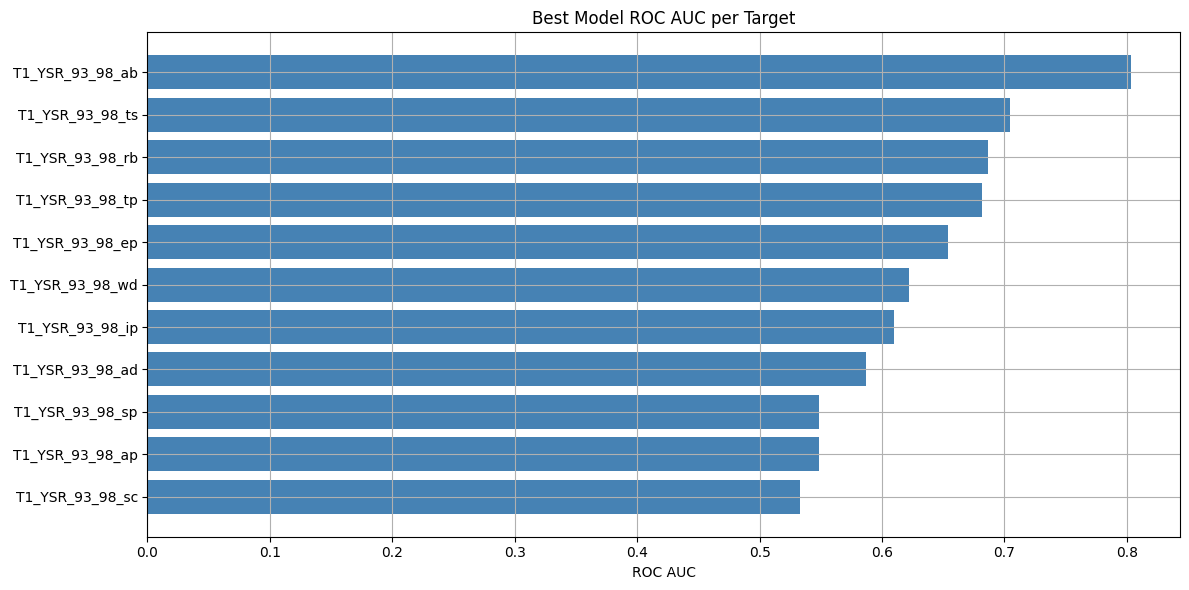

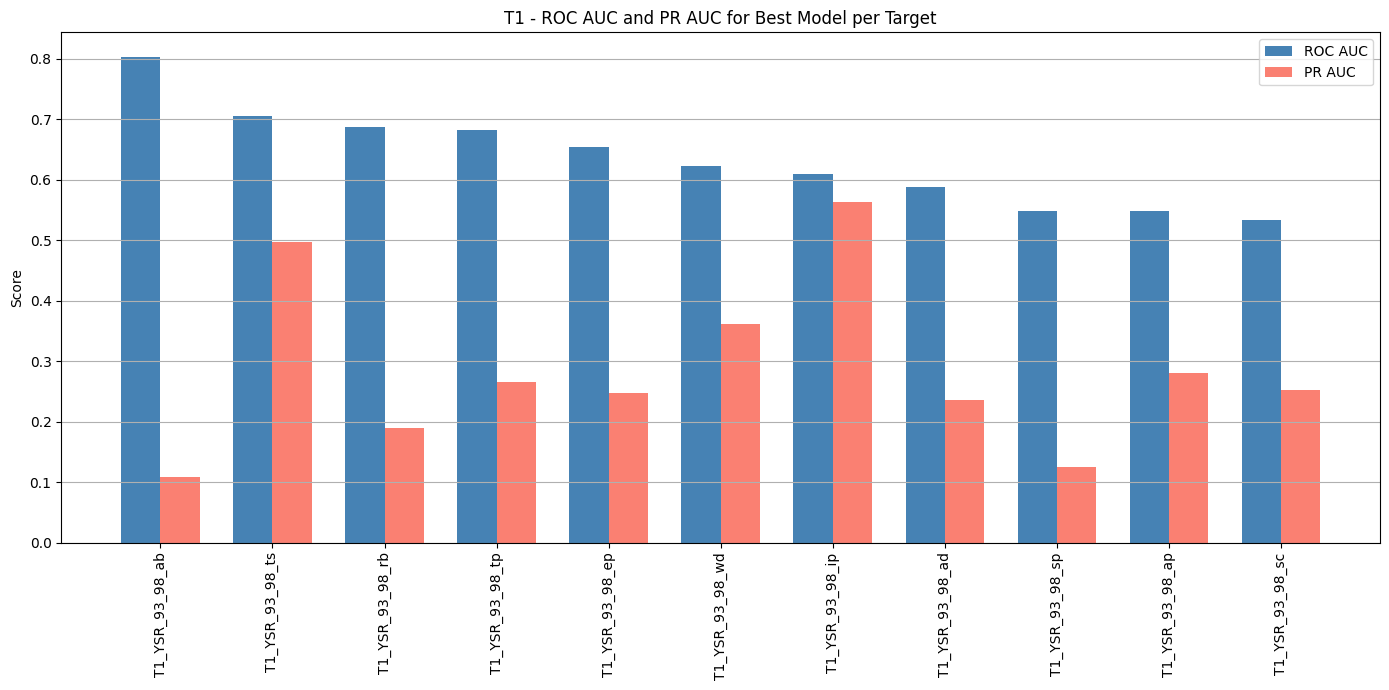

In [5]:
import pandas as pd

df_results = pd.read_csv("logistic_regression_metrics_all_targets_T1.csv")
best_models = (
    df_results
    .sort_values(by="ROC AUC", ascending=False)
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)

display(best_models[["Target", "Model", "ROC AUC", "PR AUC", "F1"]])
import matplotlib.pyplot as plt

# Sort for better visualization
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("T1 - ROC AUC and PR AUC for Best Model per Target")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# best model based on PR

In [7]:
#choosing best models based on PR AUC instead of ROC AUC
#Filter valid models
df_valid = df_results.dropna(subset=["PR AUC", "F1"])

# Choose best by PR AUC, break ties with F1
best_models = (
    df_valid
    .sort_values(by=["Target", "PR AUC", "F1"], ascending=[True, False, False])
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)


In [8]:
best_models

,Target,Model,ROC AUC,PR AUC,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
0,T1_YSR_93_98_ab,KBest - L1,0.803279,0.108333,0.619048,0.076923,1.000000,0.142857,2,37,24,0
1,T1_YSR_93_98_ad,PCA - SMOTE,0.587037,0.235230,0.546875,0.193548,0.600000,0.292683,6,29,25,4
2,T1_YSR_93_98_ap,No FS - L1,0.540136,0.301758,0.562500,0.157895,0.200000,0.176471,3,33,16,12
3,T1_YSR_93_98_ep,No FS - L1,0.606996,0.273131,0.746032,0.230769,0.333333,0.272727,3,44,10,6
4,T1_YSR_93_98_ip,PCA - Balanced,0.606430,0.565667,0.603175,0.444444,0.545455,0.489796,12,26,15,10
5,T1_YSR_93_98_rb,KBest - Balanced,0.686224,0.189360,0.650794,0.200000,0.714286,0.312500,5,36,20,2
6,T1_YSR_93_98_sc,No FS - L1,0.533333,0.251974,0.750000,0.111111,0.111111,0.111111,1,47,8,8
7,T1_YSR_93_98_sp,PCA - L1,0.488722,0.136868,0.500000,0.068966,0.285714,0.111111,2,30,27,5
8,T1_YSR_93_98_tp,No FS - L1,0.681818,0.264738,0.682540,0.200000,0.500000,0.285714,4,39,16,4
9,T1_YSR_93_98_ts,No FS - L1,0.704604,0.497287,0.571429,0.343750,0.647059,0.448980,11,25,21,6


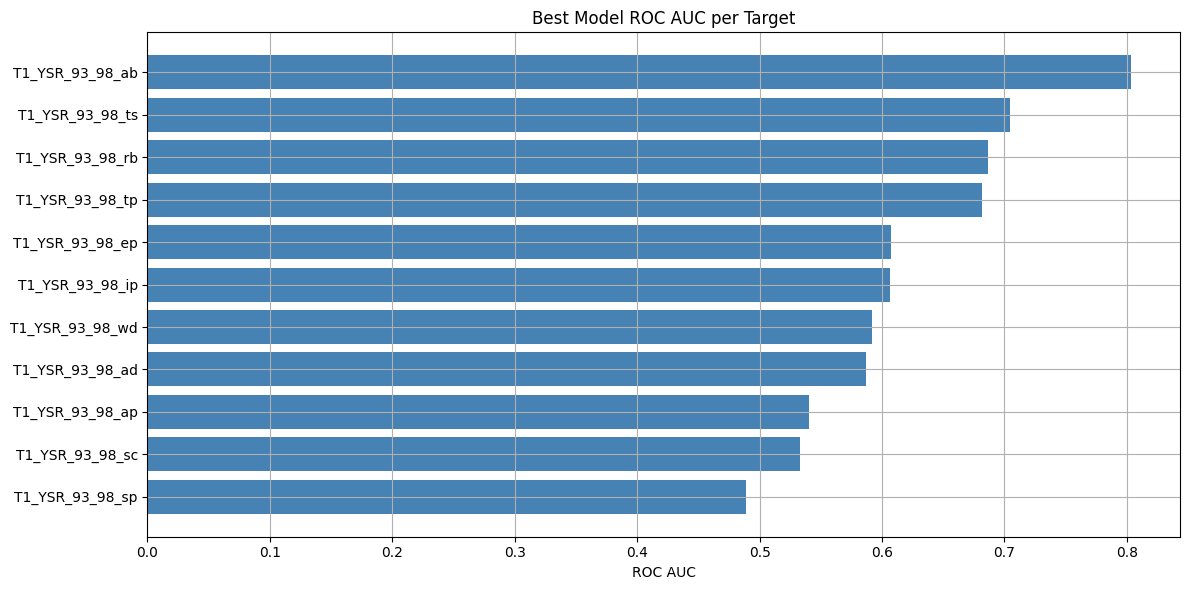

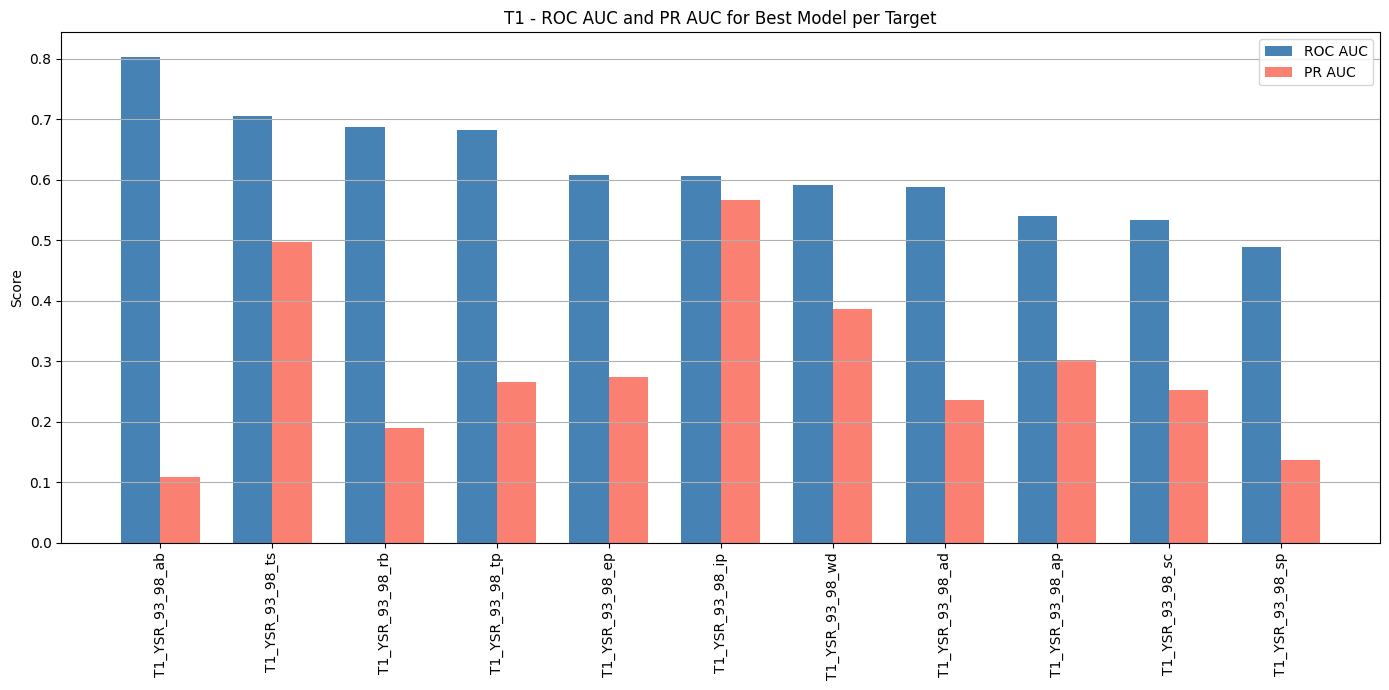

In [9]:
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("T1 - ROC AUC and PR AUC for Best Model per Target")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import RobustScaler


In [13]:
import pandas as pd
df = pd.read_excel("excel_files/test_T1.xlsx",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"])
df = df.apply(pd.to_numeric, errors="coerce")
target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]

df[target_columns] = df[target_columns].replace(2, 1)

In [15]:
positive_class_ratios = df[target_columns].mean()

# Display the result
print(positive_class_ratios)


T1_YSR_93_98_ad    0.156010
T1_YSR_93_98_wd    0.212435
T1_YSR_93_98_sc    0.131105
T1_YSR_93_98_sp    0.109974
T1_YSR_93_98_tp    0.123711
T1_YSR_93_98_ap    0.235294
T1_YSR_93_98_rb    0.118557
T1_YSR_93_98_ab    0.030928
T1_YSR_93_98_ip    0.335052
T1_YSR_93_98_ep    0.141753
T1_YSR_93_98_ts    0.265464
dtype: float64


# quick XGBoost test

In [14]:
target = 'T1_YSR_93_98_ip'

# Drop NaNs in target or acoustic features
df_ip = df[[target]].join(df[df.columns[79:]]).dropna()

X = df_ip[df.columns[79:]]
y = df_ip[target]

# Optional: see class imbalance
print("Positive class ratio:", y.mean())


Positive class ratio: 0.34394904458598724


In [16]:
# Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_selected = selector.fit_transform(X, y)

# Normalize features (XGBoost doesn't require it, but it helps interpretability sometimes)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [18]:
# Compute class imbalance ratio
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:24:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")


ROC AUC: 0.671
PR AUC: 0.551
Precision: 0.471
Recall: 0.364
F1 Score: 0.410
Accuracy: 0.635
Confusion Matrix: TP=8, FP=9, FN=14, TN=32


# PQ16 tests with both DFs ( baseline and T1)

In [1]:
import pandas as pd
import numpy as np
# Load the files
df_baseline = pd.read_csv("excel_files/baseline_features.csv",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df_baseline = df_baseline.apply(pd.to_numeric, errors="coerce")
df_baseline = df_baseline[df_baseline.isnull().sum(axis=1) <= 500]

cols_to_check = df_baseline.columns[60:]
cols_to_keep = [col for col in cols_to_check if col.startswith("baseline_")]
df_baseline = df_baseline[df_baseline.columns[:60].tolist() + cols_to_keep]

df_t1 = pd.read_excel("excel_files/test_T1.xlsx",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df_t1 = df_t1.drop(columns=["helper"])
df_t1 = df_t1.apply(pd.to_numeric, errors="coerce")

# Rename the target column in T1 to match baseline, if needed
df_t1 = df_t1.rename(columns={"T1_PQ16_sum": "PQ16_sum"})

# Check if ID column exists in both
if "ID_Alexandra" in df_baseline.columns and "ID_Alexandra" in df_t1.columns:
    # Find common IDs
    common_ids = set(df_baseline["ID_Alexandra"]).intersection(set(df_t1["ID_Alexandra"]))
    print(f"Number of common patients: {len(common_ids)}")

    # Optionally: show common IDs
    print("Sample of common IDs:", list(common_ids)[:10])

else:
    print("ID_Alexandra column not found in both files.")


Number of common patients: 333
Sample of common IDs: [5, 6, 8, 14, 15, 16, 24, 28, 31, 34]


In [2]:
df_baseline.columns[50:60]

Index(['YSR_98_DSM_som', 'YSR_98_DSM_att', 'YSR_98_DSM_opp', 'YSR_98_DSM_con',
       'PQ16_sum', 'PQ16_cut_off', 'PQ_sum_sqrt', 'PQ14_sum',
       'PQ14_hallucinations', 'PQ14_delusions'],
      dtype='object')

In [3]:
df_t1.shape

(391, 1078)

In [4]:
df_t1.columns[70:80]

Index(['T1_YSR_98_DSM_som', 'T1_YSR_98_DSM_att', 'T1_YSR_98_DSM_opp',
       'T1_YSR_98_DSM_con', 'PQ16_sum', 'T1_PQ16_cut_off', 'T1_PQ14_sum',
       'T1_PQ14_hallucinations', 'T1_PQ14_delusions', 't1_avgDF0'],
      dtype='object')

In [2]:
# Step 1: Extract acoustic columns
acoustic_cols_baseline = df_baseline.columns[60:]
acoustic_cols_t1 = df_t1.columns[79:]

# Step 2: Remove prefixes
def strip_prefix(cols, prefix):
    return [col[len(prefix):] if col.startswith(prefix) else col for col in cols]

acoustic_baseline_clean = strip_prefix(acoustic_cols_baseline, "baseline_")
acoustic_t1_clean = strip_prefix(acoustic_cols_t1, "t1_")

# Step 3: Convert to sets
set_baseline = set(acoustic_baseline_clean)
set_t1 = set(acoustic_t1_clean)

# Step 4: Compare
common_features = set_baseline.intersection(set_t1)

print(f"Number of acoustic features in baseline: {len(set_baseline)}")
print(f"Number of acoustic features in T1: {len(set_t1)}")
print(f"Number of common acoustic features: {len(common_features)}")


Number of acoustic features in baseline: 1027
Number of acoustic features in T1: 999
Number of common acoustic features: 999


In [3]:
# Step 1: Identify the cleaned acoustic feature names
acoustic_cols_baseline_raw = df_baseline.columns[60:]
acoustic_cols_t1_raw = df_t1.columns[79:]

def strip_prefix(cols, prefix):
    return [col[len(prefix):] if col.startswith(prefix) else col for col in cols]

baseline_clean_names = strip_prefix(acoustic_cols_baseline_raw, "baseline_")
t1_clean_names = strip_prefix(acoustic_cols_t1_raw, "t1_")

# Step 2: Find 999 common features
common_features = list(set(baseline_clean_names).intersection(set(t1_clean_names)))

# Step 3: Map back to original column names
baseline_feature_map = {col: col[len("baseline_"):] if col.startswith("baseline_") else col for col in acoustic_cols_baseline_raw}
t1_feature_map = {col: col[len("t1_"):] if col.startswith("t1_") else col for col in acoustic_cols_t1_raw}

baseline_common_cols = [col for col in acoustic_cols_baseline_raw if baseline_feature_map[col] in common_features]
t1_common_cols = [col for col in acoustic_cols_t1_raw if t1_feature_map[col] in common_features]

# Step 4: Align both DataFrames by ID
common_ids = set(df_baseline["ID_Alexandra"]).intersection(df_t1["ID_Alexandra"])
df_base_common = df_baseline[df_baseline["ID_Alexandra"].isin(common_ids)].copy()
df_t1_common = df_t1[df_t1["ID_Alexandra"].isin(common_ids)].copy()

df_base_common.set_index("ID_Alexandra", inplace=True)
df_t1_common.set_index("ID_Alexandra", inplace=True)

# Step 5: Compute clinical score differences
pq16_diff = (df_t1_common["PQ16_sum"] - df_base_common["PQ16_sum"]).rename("PQ16_sum_diff")
pq14_delusions_diff = (df_t1_common["T1_PQ14_delusions"] - df_base_common["PQ14_delusions"]).rename("PQ14_delusions_diff")
pq14_hallucinations_diff = (df_t1_common["T1_PQ14_hallucinations"] - df_base_common["PQ14_hallucinations"]).rename("PQ14_hallucinations_diff")

# Step 6: Compute acoustic feature differences
baseline_features = df_base_common[baseline_common_cols]
baseline_features.columns = [baseline_feature_map[col] for col in baseline_common_cols]

t1_features = df_t1_common[t1_common_cols]
t1_features.columns = [t1_feature_map[col] for col in t1_common_cols]

acoustic_diff = t1_features[common_features] - baseline_features[common_features]
acoustic_diff.columns = [col + "_diff" for col in acoustic_diff.columns]

# Step 7: Final output
df_diff_final = pd.concat([
    pq16_diff,
    pq14_delusions_diff,
    pq14_hallucinations_diff,
    acoustic_diff
], axis=1).reset_index()

# Preview
print("Final shape:", df_diff_final.shape)
df_diff_final.head()


Final shape: (333, 1003)


,ID_Alexandra,PQ16_sum_diff,PQ14_delusions_diff,PQ14_hallucinations_diff,skewnessMFCCon_1_diff,avgBBEon_1_diff,paa_mfcc_5_skew_diff,paa_deltaspectral_flux_mean_diff,paa_deltamfcc_13_min_diff,avgMFCCoff_1_diff,...,skewnessBBEoff_20_diff,paa_deltamfcc_10_std_diff,paa_chroma_3_mean_diff,paa_chroma_10_kurtosis_diff,paa_mfcc_13_skew_diff,avgBBEon_4_diff,skwEunvoiced_diff,avg1Eunvoiced_diff,paa_deltamfcc_3_max_diff,avgMFCCoff_12_diff
0,5,-3.0,-1.0,-1.0,-3.433926e+16,-2.883795e+16,0.235740,1.098701e+10,0.235843,2.343557e-01,...,6.989415e-01,-0.010148,0.016085,1.522832e+16,-0.069722,-2.888216e+15,0.232813,-4.866883e+15,3.267627e+15,1.630542e+00
1,6,-1.0,0.0,0.0,-2.540848e+14,-2.286317e+16,0.295497,9.166863e+06,0.226769,3.941781e-02,...,3.596131e-01,0.000307,0.040003,3.521585e+16,0.045685,-3.323129e+16,0.056739,-4.297211e+15,2.502497e+16,-2.210704e+12
2,8,-1.0,-1.0,0.0,-2.392799e+16,-2.500517e+16,0.208468,7.920860e+08,0.105345,-1.070487e+16,...,1.181705e+16,0.035366,0.007604,1.156076e+16,0.073629,-3.454860e+16,0.006422,-4.308319e+16,3.032630e+15,6.854161e-01
3,14,-2.0,-1.0,0.0,-3.308535e+16,-3.157661e+16,0.245915,2.389225e+08,-0.108592,2.609392e+00,...,2.832557e-01,0.009020,0.000510,2.914917e+15,-0.068299,-3.526802e+16,0.316033,-5.108996e+16,2.599058e+15,-1.887356e+16
4,15,-5.0,-1.0,-4.0,-2.110423e+16,-2.375734e+16,0.473061,3.332234e+09,0.250129,5.997232e-01,...,4.287074e-01,0.010615,-0.010817,8.061446e+14,0.565191,-3.672531e+16,0.061228,-4.237167e+16,2.848256e+16,2.305404e-01


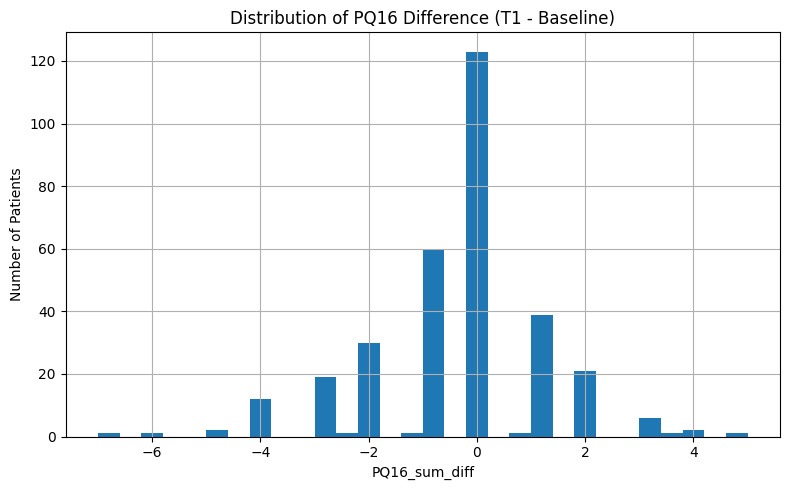

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_diff_final["PQ14_hallucinations_diff"].dropna(), bins=30)
plt.title("Distribution of PQ16 Difference (T1 - Baseline)")
plt.xlabel("PQ16_sum_diff")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Step: Compute quantiles
q25_16 = df_diff_final["PQ16_sum_diff"].quantile(0.2)
q75_16 = df_diff_final["PQ16_sum_diff"].quantile(0.8)

q25_del = df_diff_final["PQ14_delusions_diff"].quantile(0.2)
q75_del = df_diff_final["PQ14_delusions_diff"].quantile(0.8)

q25_hal = df_diff_final["PQ14_hallucinations_diff"].quantile(0.2)
q75_hal = df_diff_final["PQ14_hallucinations_diff"].quantile(0.8)

# Step: Define assignment
def assign_group(x, q25, q75):
    if x <= q25:
        return 0
    elif x >= q75:
        return 1
    else:
        return np.nan

# Step: Assign and insert all three group columns after PQ14_hallucinations_diff
insert_at = df_diff_final.columns.get_loc("PQ14_hallucinations_diff") + 1

df_diff_final.insert(
    insert_at,
    "group_PQ16",
    df_diff_final["PQ16_sum_diff"].apply(assign_group, args=(q25_16, q75_16)).astype("Int64")
)

df_diff_final.insert(
    insert_at + 1,
    "group_delusions",
    df_diff_final["PQ14_delusions_diff"].apply(assign_group, args=(q25_del, q75_del)).astype("Int64")
)

df_diff_final.insert(
    insert_at + 2,
    "group_hallucinations",
    df_diff_final["PQ14_hallucinations_diff"].apply(assign_group, args=(q25_hal, q75_hal)).astype("Int64")
)

# Preview
print("Final shape with inserted group columns:", df_diff_final.shape)
df_diff_final.loc[:, ["PQ14_hallucinations_diff", "group_PQ16", "group_delusions", "group_hallucinations"]].head()


Final shape with inserted group columns: (333, 1006)


,PQ14_hallucinations_diff,group_PQ16,group_delusions,group_hallucinations
0,-1.0,0,0,<NA>
1,0.0,<NA>,<NA>,<NA>
2,0.0,<NA>,0,<NA>
3,0.0,<NA>,0,<NA>
4,-4.0,0,0,0


In [6]:
df_diff_final

,ID_Alexandra,PQ16_sum_diff,PQ14_delusions_diff,PQ14_hallucinations_diff,group_PQ16,group_delusions,group_hallucinations,skewnessMFCCon_1_diff,avgBBEon_1_diff,paa_mfcc_5_skew_diff,...,skewnessBBEoff_20_diff,paa_deltamfcc_10_std_diff,paa_chroma_3_mean_diff,paa_chroma_10_kurtosis_diff,paa_mfcc_13_skew_diff,avgBBEon_4_diff,skwEunvoiced_diff,avg1Eunvoiced_diff,paa_deltamfcc_3_max_diff,avgMFCCoff_12_diff
0,5,-3.0,-1.0,-1.0,0,0,<NA>,-3.433926e+16,-2.883795e+16,0.235740,...,6.989415e-01,-0.010148,0.016085,1.522832e+16,-0.069722,-2.888216e+15,0.232813,-4.866883e+15,3.267627e+15,1.630542e+00
1,6,-1.0,0.0,0.0,<NA>,<NA>,<NA>,-2.540848e+14,-2.286317e+16,0.295497,...,3.596131e-01,0.000307,0.040003,3.521585e+16,0.045685,-3.323129e+16,0.056739,-4.297211e+15,2.502497e+16,-2.210704e+12
2,8,-1.0,-1.0,0.0,<NA>,0,<NA>,-2.392799e+16,-2.500517e+16,0.208468,...,1.181705e+16,0.035366,0.007604,1.156076e+16,0.073629,-3.454860e+16,0.006422,-4.308319e+16,3.032630e+15,6.854161e-01
3,14,-2.0,-1.0,0.0,<NA>,0,<NA>,-3.308535e+16,-3.157661e+16,0.245915,...,2.832557e-01,0.009020,0.000510,2.914917e+15,-0.068299,-3.526802e+16,0.316033,-5.108996e+16,2.599058e+15,-1.887356e+16
4,15,-5.0,-1.0,-4.0,0,0,0,-2.110423e+16,-2.375734e+16,0.473061,...,4.287074e-01,0.010615,-0.010817,8.061446e+14,0.565191,-3.672531e+16,0.061228,-4.237167e+16,2.848256e+16,2.305404e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1009,1.0,0.0,1.0,1,<NA>,1,-3.273474e+15,-1.134600e+16,0.968395,...,1.517864e+16,-0.010217,-0.059575,8.188095e+14,0.769485,-3.503316e+16,0.096184,-4.422424e+15,2.401526e+16,-1.089489e+00
329,1016,0.0,0.0,0.0,<NA>,<NA>,<NA>,-4.346155e+15,-3.728339e+15,0.231494,...,1.560002e+16,-0.012728,-0.018193,9.752618e+15,0.455659,-4.919892e+15,0.256320,-6.016198e+15,3.081138e+15,2.802194e+00
330,1017,-3.0,-1.0,-1.0,0,0,<NA>,-2.297415e+16,-3.157636e+16,0.164342,...,5.146615e-02,0.003718,0.000400,5.637213e+16,0.169310,-3.654815e+16,0.080208,-5.968195e+15,3.191767e+16,1.199678e+16
331,1018,1.0,0.0,0.0,1,<NA>,<NA>,-3.374897e+16,-2.318353e+15,-0.011269,...,6.046379e-01,-0.029077,0.028764,5.676620e+15,0.112775,-3.128527e+16,0.300876,-3.369967e+15,2.977486e+15,9.183044e-01


In [8]:
group_cols = ['group_PQ16', 'group_delusions', 'group_hallucinations']

for col in group_cols:
    counts = df_diff_final[col].value_counts(dropna=True)
    print(f"\n{col}:")
    print(f"0s: {counts.get(0, 0)}")
    print(f"1s: {counts.get(1, 0)}")



group_PQ16:
0s: 65
1s: 88

group_delusions:
0s: 100
1s: 76

group_hallucinations:
0s: 66
1s: 70


In [7]:
value_counts = df_diff_final['group_hallucinations'].value_counts(dropna=False)

# Rename index so <NA> appears as string for clarity (optional)
value_counts.index = value_counts.index.map(lambda x: '<NA>' if pd.isna(x) else x)

print(value_counts)


group_hallucinations
<NA>    197
1.0      70
0.0      66
Name: count, dtype: Int64


# running the 9 logreg variations with PQ16

In [ ]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from collections import Counter

from joblib import Parallel, delayed


def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

from imblearn.over_sampling import SMOTE

def safe_smote(X, y, random_state=42):
    # Count minority class samples
    from collections import Counter
    counter = Counter(y)
    min_class_count = min(counter.values())

    # Avoid errors by capping k_neighbors
    k = min(3, min_class_count - 1) if min_class_count > 1 else 1

    return SMOTE(k_neighbors=k, random_state=random_state).fit_resample(X, y)
cv_results = []
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}
targets_5050 = ['group_PQ16', 'group_delusions', 'group_hallucinations']

# Automatically get acoustic feature columns (assumes ID, PQ16_diff, group are first 3)
acoustic_features = df_diff_final.columns[7:]


for target in tqdm(targets_5050):
    data = df_diff_final[[target]].join(df_diff_final[df_diff_final.columns[7:]]).dropna()
    y = data[target]
    X = data[df_diff_final.columns[7:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models_5050.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df_5050 = pd.DataFrame(cv_results)
#cv_df_5050.to_csv("CV_BASELINE_all_models_5050.csv", index=False)
# Example: find best model per target
best_models_df_5050 = cv_df_5050.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()

final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models_5050[model_name])

    # Prepare data
    data = df_diff_final[[target]].join(df_diff_final[df_diff_final.columns[7:]]).dropna()
    y = data[target]
    X = data[df_diff_final.columns[7:]]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Threshold tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5
        best_f1 = np.nan

    # Predict with threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

    # Precision at 70% recall
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= 0.7]
    precision_at_70recall = max([precisions[i] for i in valid_idxs_70]) if valid_idxs_70 else np.nan

    # Confusion matrix
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # ---- Extract Top 3 Features (keep full names) ----
    if "PCA" not in model_name:
        try:
            coefs = model.named_steps["logreg"].coef_[0] if hasattr(model, "named_steps") else model.coef_[0]
            feature_names = X.columns
            sorted_indices = np.argsort(np.abs(coefs))[::-1][:3]
            top_features = [feature_names[i] for i in sorted_indices]
            top_coefs = [coefs[i] for i in sorted_indices]
        except Exception as e:
            print(f"⚠️ Feature extraction failed for {target}: {e}")
            top_features = [""] * 3
            top_coefs = [np.nan] * 3
    else:
        top_features = [""] * 3
        top_coefs = [np.nan] * 3

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec_at_thresh,
        "Recall": recall_at_thresh,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Top Feature 1": top_features[0],
        "Top Feature 2": top_features[1],
        "Top Feature 3": top_features[2],
        "Coef 1": top_coefs[0],
        "Coef 2": top_coefs[1],
        "Coef 3": top_coefs[2],
    })

# Final dataframe
final_results_correctt0_THIS = pd.DataFrame(final_results)
#final_results_correctt0_THIS.to_csv("5050505050FINAL_TEST_with_features_BASELINE.csv", index=False)
final_results_correctt0_THIS.to_csv("PQ_EXPERIMENTS.csv", index=False)
import matplotlib.pyplot as plt

In [41]:
def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]
    short_labels = [label.split('_')[1] for label in target_order]

    # Metric configurations
    metrics = [
        ("F1", "F1 Score", "thistle", "Score"),                # softer purple
        ("Balanced Accuracy", "Balanced Accuracy", "lightcoral", "Score"),  # softer red/tomato
        ("Precision@70%Recall", "Precision at 70% Recall", "darkseagreen", "Precision")  # softer green
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        #ax.set_ylabel(ylabel, fontsize=14)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=11)

    # Make x-axis labels bold
    axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()

In [27]:
final_results_correctt0_THIS

,Target,Model,Accuracy,Precision,Recall,F1 (test),Balanced Accuracy (test),Threshold Used,F1 at Threshold,Precision@70%Recall,TP,TN,FP,FN,Top Feature 1,Top Feature 2,Top Feature 3,Coef 1,Coef 2,Coef 3
0,group_PQ16,No FS - ElasticNet,0.700000,0.714286,0.833333,0.769231,0.666667,0.481453,0.769231,0.714286,10,4,4,2,avgDDMFCCon_9_diff,avgDMFCCon_5_diff,paa_mfcc_4_mean_diff,1.090254e-16,-1.071256e-16,1.036810e-16
1,group_delusions,No FS - ElasticNet,0.416667,0.416667,1.000000,0.588235,0.500000,0.023506,0.588235,0.416667,10,0,14,0,stdMFCCon_1_diff,stdMFCCon_9_diff,paa_chroma_12_min_diff,-1.280732e-16,-1.124924e-16,1.097878e-16
2,group_hallucinations,No FS - ElasticNet,0.736842,0.692308,0.900000,0.782609,0.727778,0.195513,0.782609,0.777778,9,5,4,1,kurtosisBBEon_2_diff,paa_chroma_12_min_diff,stdMFCCon_9_diff,-1.314974e-16,9.770755e-17,-9.693547e-17


/tmp/ipykernel_1491282/1466653555.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')


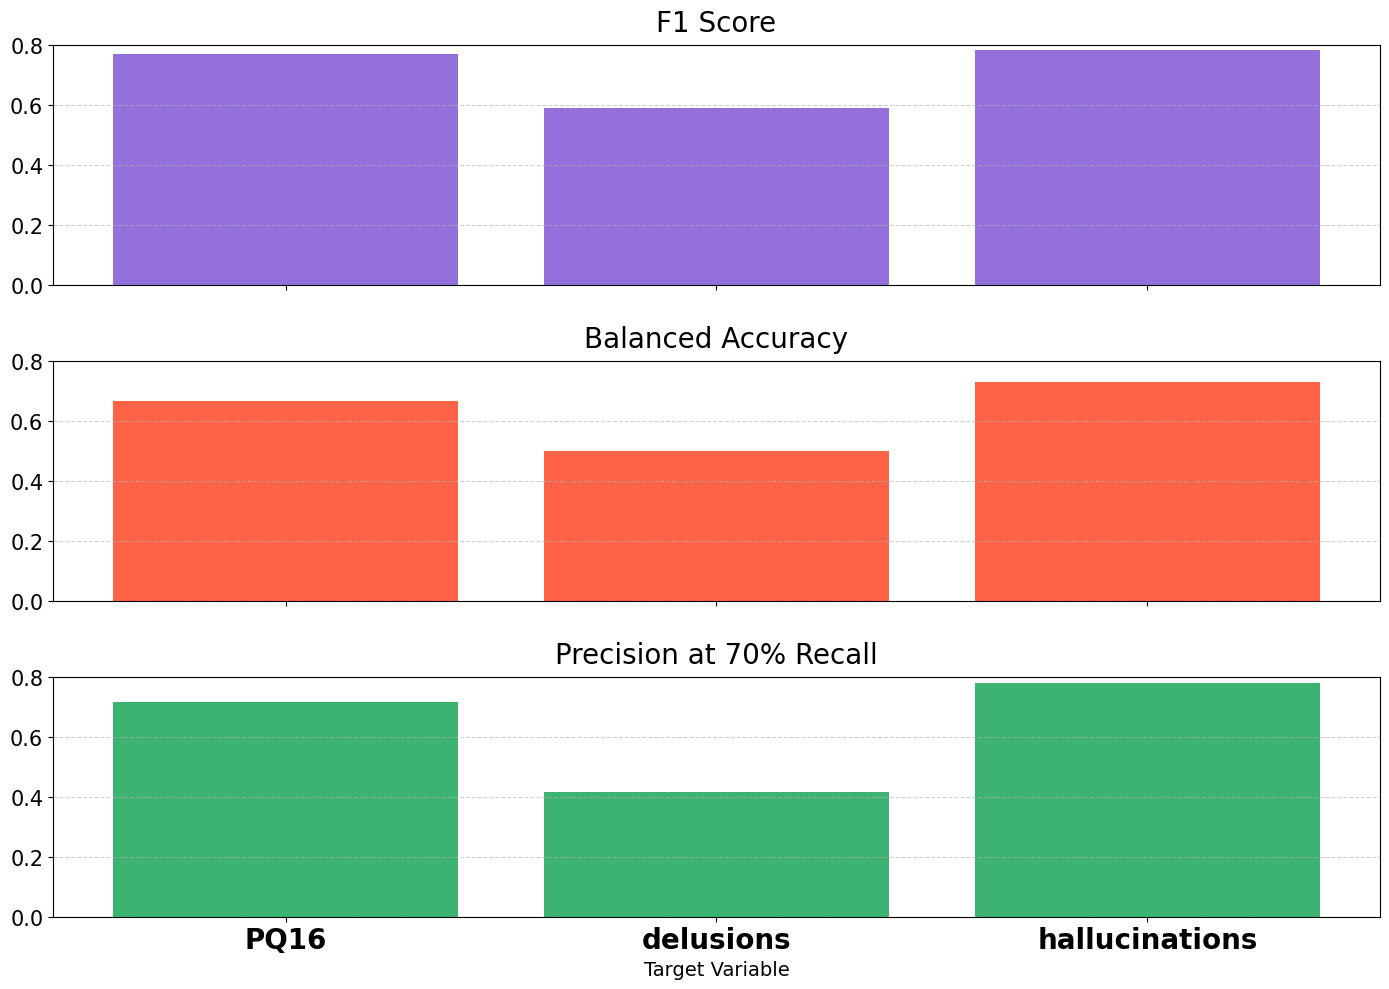

In [32]:
plot_combined_metrics(final_results_correctt0_THIS)

In [8]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, balanced_accuracy_score,
    accuracy_score, confusion_matrix, precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm
import pandas as pd
import numpy as np

feature_cols = df_diff_final.columns[7:]  # Adjust if needed

k_values = [30, 50, 100]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
targets_5050 = ['group_PQ16', 'group_delusions', 'group_hallucinations']
for target in tqdm(targets_5050):
    data = df_diff_final[[target] + list(feature_cols)].dropna()
    y_all = data[target]
    X_all = data[feature_cols]

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
    )

    best_f1 = -np.inf
    best_k = None
    best_threshold = 0.5

    for k in k_values:
        fold_metrics = []

        for train_idx, val_idx in cv.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
            y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            X_train_sel = selector.fit_transform(X_train_scaled, y_train)
            X_val_sel = selector.transform(X_val_scaled)

            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='hist',
                device='cuda',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                verbosity=0,
                random_state=42
            )
            model.fit(X_train_sel, y_train)
            y_proba = model.predict_proba(X_val_sel)[:, 1]

            precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
            valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

            threshold = 0.5
            if valid_idxs:
                best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
                threshold = thresholds[best_idx]

            y_pred = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            fold_metrics.append(f1)

        avg_f1 = np.mean(fold_metrics)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Final model on trainval, test on holdout
    scaler = RobustScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_trainval_sel = selector.fit_transform(X_trainval_scaled, y_trainval)

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        verbosity=0,
        random_state=42
    )
    model.fit(X_trainval_sel, y_trainval)

    X_test_scaled = scaler.transform(X_test)
    X_test_sel = selector.transform(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_sel)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    threshold = 0.5
    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]

    y_pred_test = (y_proba_test >= threshold).astype(int)

    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    acc = accuracy_score(y_test, y_pred_test)
    precision_at_70 = precision if recall >= 0.7 else np.nan
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_all.columns[selected_feature_indices]
    importances = model.get_booster().get_score(importance_type='gain')
    feature_importance = {
    selected_feature_names[int(k[1:])]: v for k, v in importances.items()}


    results.append({
        "Target": target,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Threshold": threshold,
        "k": best_k,
        "Selected Features": list(selected_feature_names),
        "Feature Importances": feature_importance
    })

results_df = pd.DataFrame(results)
######checkpoint

100%|██████████| 3/3 [02:40<00:00, 53.46s/it]


In [9]:
results_df.to_csv("hopefullylastone.csv", index=False)

In [43]:
results_df.to_csv("PQ_xgboost.csv", index=False)


In [37]:
results_df

,Target,F1,Balanced Accuracy,Precision,Recall,Accuracy,Precision@70%Recall,TP,TN,FP,FN,Threshold,k
0,group_PQ16,0.800000,0.625000,0.666667,1.0,0.700000,0.666667,12,2,6,0,0.096825,30
1,group_delusions,0.606061,0.535714,0.434783,1.0,0.458333,0.434783,10,1,13,0,0.019645,30
2,group_hallucinations,0.714286,0.555556,0.555556,1.0,0.578947,0.555556,10,1,8,0,0.158351,100


/tmp/ipykernel_1491282/268588528.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')


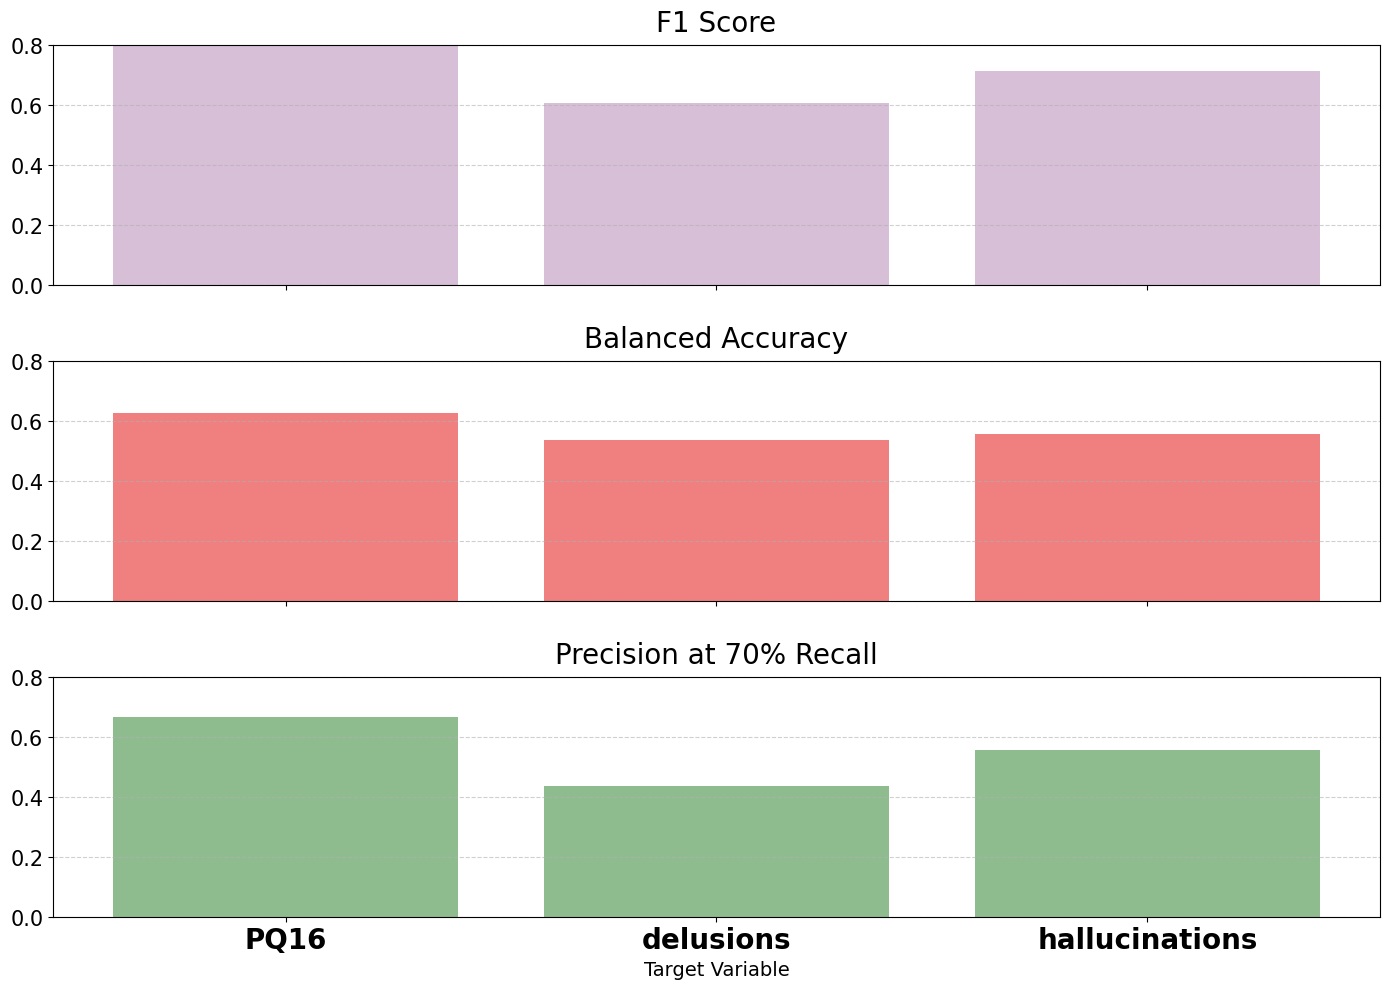

In [42]:
plot_combined_metrics(results_df)

In [75]:
import pandas as pd

df_results = pd.read_csv("logreg_PQ16_comparison.csv")

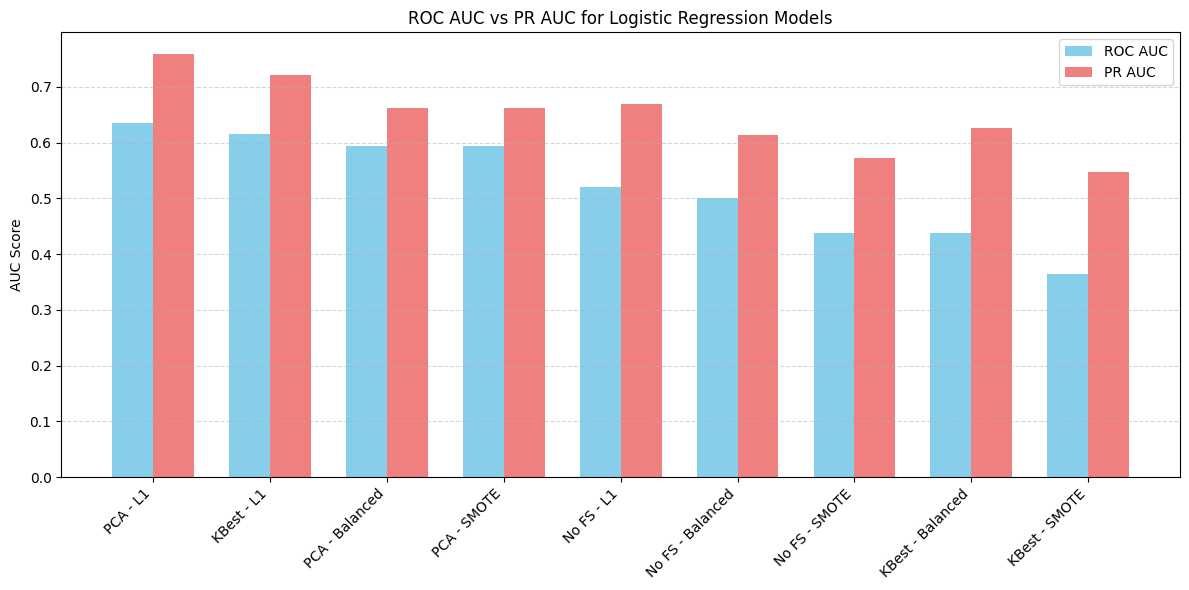

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC or keep original order
df_plot = df_results.sort_values(by="ROC AUC", ascending=False)

# Bar width and position
x = np.arange(len(df_plot))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_plot["ROC AUC"], width, label="ROC AUC", color="skyblue")
plt.bar(x + width/2, df_plot["PR AUC"], width, label="PR AUC", color="lightcoral")

# Labels and aesthetics
plt.xticks(ticks=x, labels=df_plot["Model"], rotation=45, ha='right')
plt.ylabel("AUC Score")
plt.title("ROC AUC vs PR AUC for Logistic Regression Models")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [27]:
from sklearn.model_selection import StratifiedKFold
target_columns = ['group_PQ16', 'group_delusions', 'group_hallucinations']

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for target in tqdm(target_columns):
    # Step 1: Filter rows with NaNs
    data = df_diff_final[[target]].join(df_diff_final[acoustic_features]).dropna()
    y = data[target]
    X = data[acoustic_features]

    if y.nunique() < 2:
        continue

    for model_name, model in models.items():
        try:
            metrics_list = []

            for train_idx, test_idx in cv.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                y_proba = model.predict_proba(X_test)[:, 1]
                y_pred = model.predict(X_test)

                metrics_list.append({
                    "roc_auc": roc_auc_score(y_test, y_proba),
                    "pr_auc": average_precision_score(y_test, y_proba),
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, zero_division=0),
                    "recall": recall_score(y_test, y_pred, zero_division=0),
                    "f1": f1_score(y_test, y_pred, zero_division=0),
                    **dict(zip(["tn", "fp", "fn", "tp"], confusion_matrix(y_test, y_pred).ravel()))
                })

            # Average across folds
            avg_metrics = pd.DataFrame(metrics_list).mean().to_dict()
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": avg_metrics["roc_auc"],
                "PR AUC": avg_metrics["pr_auc"],
                "Accuracy": avg_metrics["accuracy"],
                "Precision": avg_metrics["precision"],
                "Recall": avg_metrics["recall"],
                "F1": avg_metrics["f1"],
                "TP": avg_metrics["tp"],
                "TN": avg_metrics["tn"],
                "FP": avg_metrics["fp"],
                "FN": avg_metrics["fn"]
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "PR AUC": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

# Save results
results_df_grouped = pd.DataFrame(results)
results_df_grouped.to_csv("logreg_PQ16_comparison_HAL_DEL_CROSSVAL.csv", index=False)

# Show top
display(results_df_grouped.sort_values(by="ROC AUC", ascending=False))


  0%|          | 0/3 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached

,Target,Model,ROC AUC,PR AUC,Accuracy,Precision,Recall,F1,TP,TN,FP,FN
26,group_hallucinations,PCA - L1,0.602500,0.706534,0.611696,0.725769,0.607273,0.620546,6.2,5.2,3.2,4.0
24,group_hallucinations,PCA - Balanced,0.596894,0.635506,0.589474,0.666026,0.587273,0.600276,6.0,5.0,3.4,4.2
25,group_hallucinations,PCA - SMOTE,0.588169,0.628479,0.578363,0.634744,0.587273,0.593772,6.0,4.8,3.6,4.2
14,group_delusions,KBest - L1,0.554346,0.595184,0.548188,0.480220,0.510909,0.489719,5.2,7.6,5.6,5.0
10,group_delusions,No FS - SMOTE,0.541618,0.509039,0.513043,0.441616,0.412727,0.426065,4.2,7.8,5.4,6.0
20,group_hallucinations,No FS - L1,0.539773,0.656693,0.568421,0.670552,0.565455,0.577394,5.8,4.8,3.6,4.4
9,group_delusions,No FS - Balanced,0.532428,0.513446,0.487681,0.404444,0.374545,0.388421,3.8,7.6,5.6,6.4
8,group_PQ16,PCA - L1,0.515878,0.648568,0.515789,0.605051,0.492424,0.518784,5.6,4.6,3.8,5.8
18,group_hallucinations,No FS - Balanced,0.512500,0.599165,0.578947,0.627143,0.623636,0.599714,6.4,4.4,4.0,3.8
1,group_PQ16,No FS - SMOTE,0.512184,0.599292,0.536316,0.602424,0.524242,0.555888,6.0,4.6,3.8,5.4


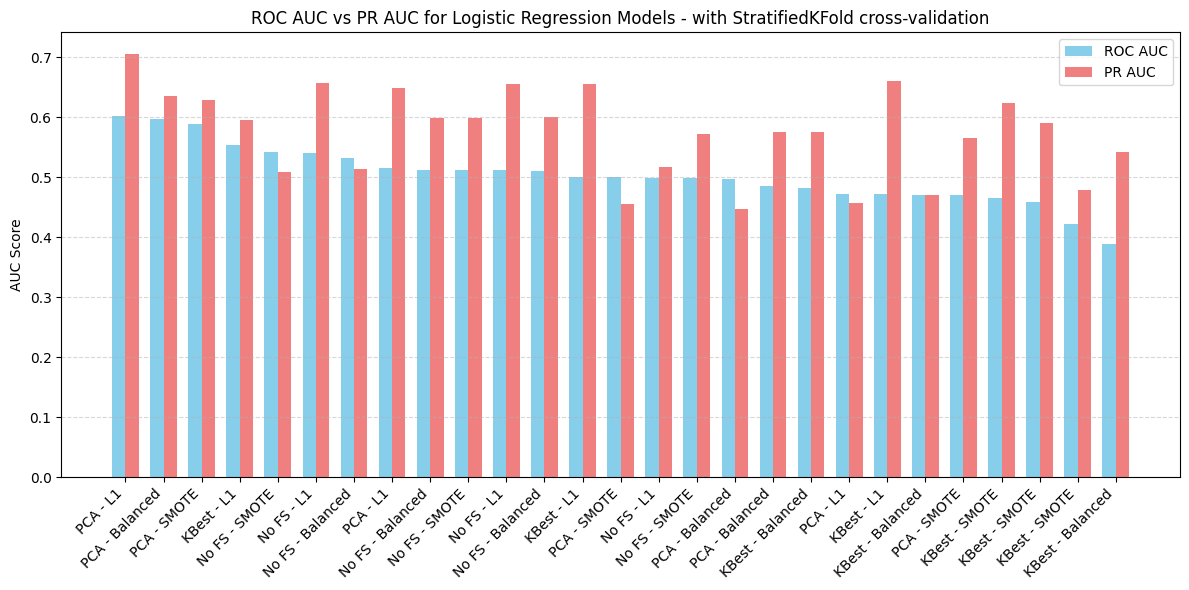

In [28]:
import pandas as pd

df_results = pd.read_csv("logreg_PQ16_comparison_HAL_DEL_CROSSVAL.csv")
import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC or keep original order
df_plot = df_results.sort_values(by="ROC AUC", ascending=False)

# Bar width and position
x = np.arange(len(df_plot))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_plot["ROC AUC"], width, label="ROC AUC", color="skyblue")
plt.bar(x + width/2, df_plot["PR AUC"], width, label="PR AUC", color="lightcoral")

# Labels and aesthetics
plt.xticks(ticks=x, labels=df_plot["Model"], rotation=45, ha='right')
plt.ylabel("AUC Score")
plt.title("ROC AUC vs PR AUC for Logistic Regression Models - with StratifiedKFold cross-validation")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


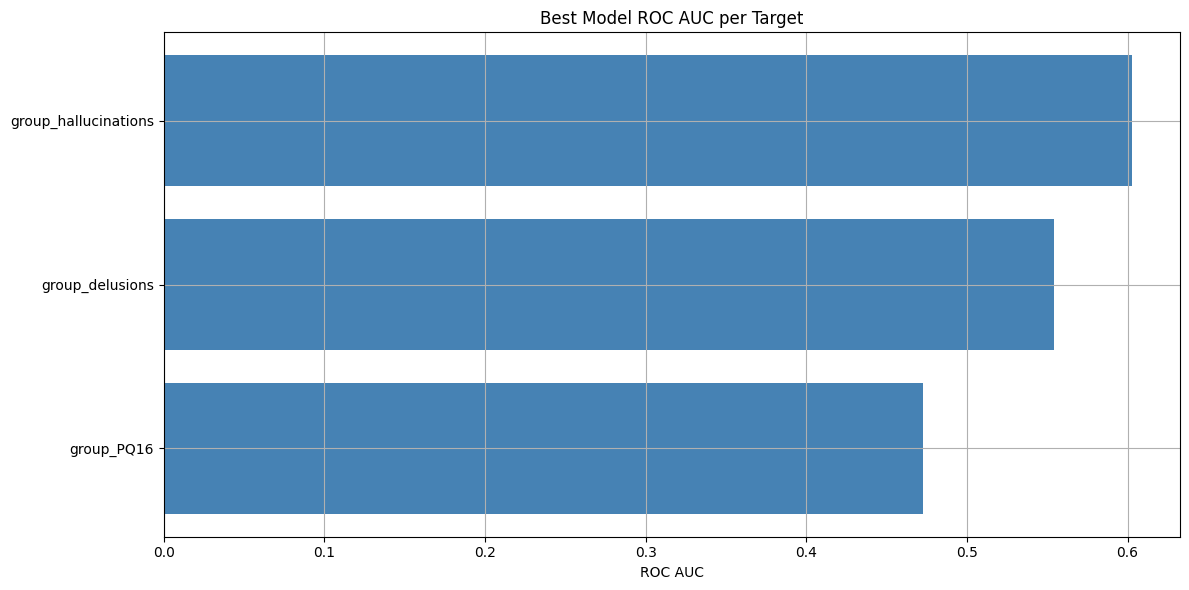

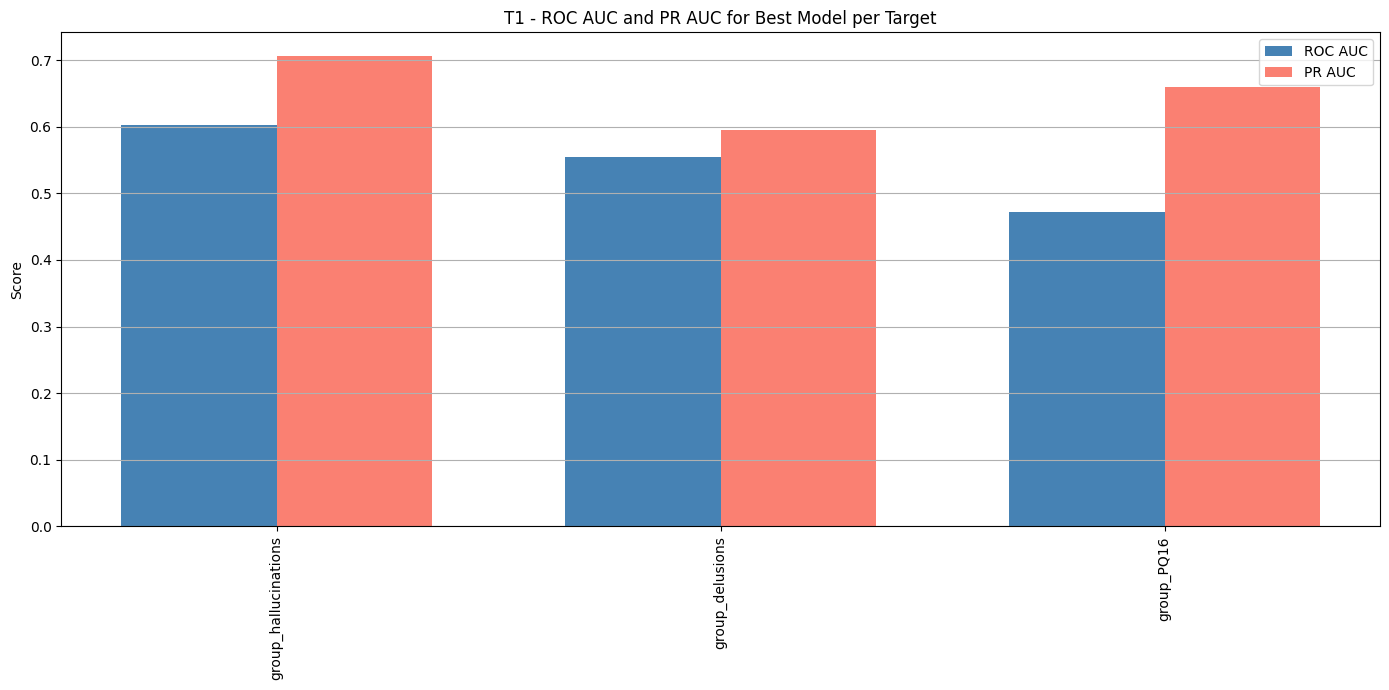

In [29]:
#choosing best models based on PR AUC instead of ROC AUC
#Filter valid models
df_valid = df_results.dropna(subset=["PR AUC", "F1"])

# Choose best by PR AUC, break ties with F1
best_models = (
    df_valid
    .sort_values(by=["Target", "PR AUC", "F1"], ascending=[True, False, False])
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)

best_models
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("T1 - ROC AUC and PR AUC for Best Model per Target")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# T1 with undersampling strategy

In [81]:
df

,ID_Alexandra,T1_PQ_sum,T1_PQ_cut_off,T1_PQ_sum_sqrt,T1_PQ_hallucinatory,T1_PQ_delusional,T1_YSR_sad,T1_YSR_swd,T1_YSR_ssc,T1_YSR_ssp,...,t1_paa_deltachroma_7_skew,t1_paa_deltachroma_7_kurtosis,t1_paa_deltachroma_8_mean,t1_paa_deltachroma_8_std,t1_paa_deltachroma_8_min,t1_paa_deltachroma_8_max,t1_paa_deltachroma_8_skew,t1_paa_deltachroma_8_kurtosis,t1_paa_deltachroma_9_mean,t1_paa_deltachroma_9_std
0,701,5.000000,0.0,2.236068,2.000000,2.0,9.0,9.0,9.0,9.0,...,-0.034772,4.726153e+15,9.024012e+06,0.009420,-0.127848,0.140847,8.674934e-01,52021185511312304,4.229201e+07,0.008712
1,14,0.000000,0.0,0.000000,0.000000,0.0,3.0,1.0,0.0,1.0,...,0.013508,6.305293e+15,5.364211e+06,0.009258,-0.183588,0.169929,-2.306139e-01,6772506439035750,4.620222e+06,0.010997
2,16,5.000000,0.0,2.236068,3.000000,1.0,2.0,1.0,2.0,3.0,...,-0.306684,1.342565e+16,1.079322e+09,0.006479,-0.090296,0.116927,3.361990e-01,61528859986647904,2.264454e+08,0.010423
3,24,1.333333,0.0,1.154701,1.285714,0.0,0.0,NaN,2.0,2.0,...,-0.003007,1.323562e+16,-5.705952e+06,0.002577,-0.071955,0.072522,1.063751e+16,22220222196569500,-1.772286e+08,0.008310
4,31,2.000000,0.0,1.414214,0.000000,2.0,1.0,4.0,0.0,3.0,...,0.024085,2.837089e+15,-3.708972e+07,0.001960,-0.049519,0.045032,-1.002676e+16,16026170113707500,1.705874e+10,0.011284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,1018,2.000000,0.0,1.414214,0.000000,1.0,11.0,7.0,3.0,3.0,...,-0.038319,4.513903e+15,-3.185445e+06,0.009313,-0.133412,0.106646,-8.218062e-01,4310372047573480,-3.796533e+06,0.006696
387,1019,1.000000,0.0,1.000000,0.000000,0.0,2.0,1.0,3.0,4.0,...,0.027890,5.747045e+14,4.700284e+08,0.015110,-0.180888,0.210146,2.989656e-01,3550598003125620,-1.330779e+10,0.015578
388,97,1.000000,0.0,1.000000,0.000000,0.0,2.0,1.0,0.0,0.0,...,-0.304740,1.222395e+16,-1.301976e+08,0.012946,-0.167177,0.139905,8.791509e-02,3272892056801130,-1.091004e+09,0.014505
389,185,9.000000,1.0,3.000000,6.000000,2.0,13.0,9.0,8.0,6.0,...,-0.167213,3.369078e+16,-1.582805e+09,0.007856,-0.060151,0.075193,1.148144e+16,3456268372219340,-1.383256e+11,0.009303


In [84]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

import pandas as pd
df = pd.read_excel("excel_files/test_T1.xlsx",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"])
df = df.apply(pd.to_numeric, errors="coerce")
target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]

df[target_columns] = df[target_columns].replace(2, 1)

results = []

for target in tqdm(target_columns):
    # Step 1: Filter rows with NaNs
    data = df[[target]].join(df[df.columns[79:]]).dropna()
    y = data[target]
    X = data[df.columns[79:]]

    # Skip if target has no variation
    if y.nunique() < 2:
        continue

    # Step 2: Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Undersample training data
    train_data = X_train.copy()
    train_data['target'] = y_train

    minority = train_data[train_data['target'] == 1]
    majority = train_data[train_data['target'] == 0]

    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority),
        random_state=42
    )

    train_balanced = pd.concat([minority, majority_downsampled])
    X_train = train_balanced.drop(columns='target')
    y_train = train_balanced['target']

    # Step 4: Define models with fresh estimators
    models = {
        "No FS - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "No FS - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=100)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=100)),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=50)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=50)),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
    }

    # Step 5: Fit + Evaluate each model
    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            # Evaluation metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            pr_auc = average_precision_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "PR AUC": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

# Save final results
results_df_complete = pd.DataFrame(results)
results_df_complete.to_csv("logistic_regression_metrics_all_targets_T1_UNDERSAMPLING.csv", index=False)

# Optional: display top models per target
display(results_df_complete.sort_values(by=["Target", "ROC AUC"], ascending=[True, False]))


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

,Target,Model,ROC AUC,PR AUC,Accuracy,Precision,Recall,F1,TP,TN,FP,FN,Error
42,T1_YSR_93_98_ab,No FS - L1 (undersampled),0.803279,0.168478,0.507937,0.060606,1.000000,0.114286,2.0,30.0,31.0,0.0,NaN
43,T1_YSR_93_98_ab,No FS - Balanced (undersampled),0.663934,0.054113,0.587302,0.038462,0.500000,0.071429,1.0,36.0,25.0,1.0,NaN
44,T1_YSR_93_98_ab,KBest - L1 (undersampled),0.532787,0.267241,0.507937,0.032258,0.500000,0.060606,1.0,31.0,30.0,1.0,NaN
45,T1_YSR_93_98_ab,KBest - Balanced (undersampled),0.336066,0.031746,0.777778,0.000000,0.000000,0.000000,0.0,49.0,12.0,2.0,NaN
46,T1_YSR_93_98_ab,PCA - L1 (undersampled),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n_components=50 must be between 0 and min(n_sa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,T1_YSR_93_98_wd,PCA - L1 (undersampled),0.556851,0.321429,0.587302,0.269231,0.500000,0.350000,7.0,30.0,19.0,7.0,NaN
8,T1_YSR_93_98_wd,KBest - L1 (undersampled),0.552478,0.346879,0.444444,0.230769,0.642857,0.339623,9.0,19.0,30.0,5.0,NaN
6,T1_YSR_93_98_wd,No FS - L1 (undersampled),0.470117,0.248424,0.444444,0.181818,0.428571,0.255319,6.0,22.0,27.0,8.0,NaN
7,T1_YSR_93_98_wd,No FS - Balanced (undersampled),0.466472,0.207506,0.444444,0.200000,0.500000,0.285714,7.0,21.0,28.0,7.0,NaN


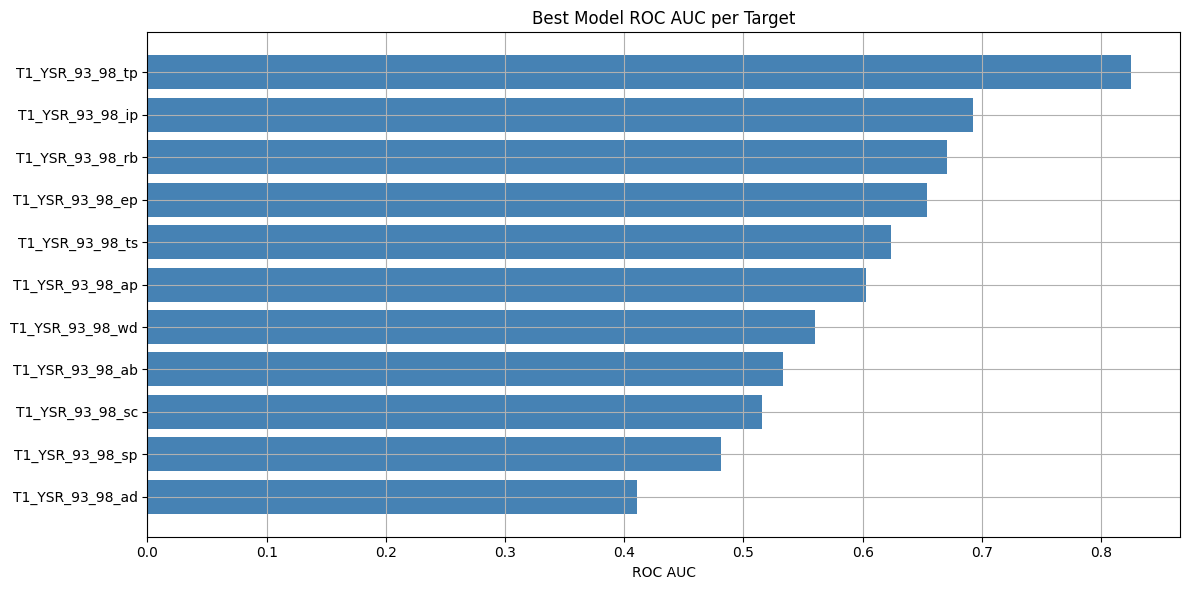

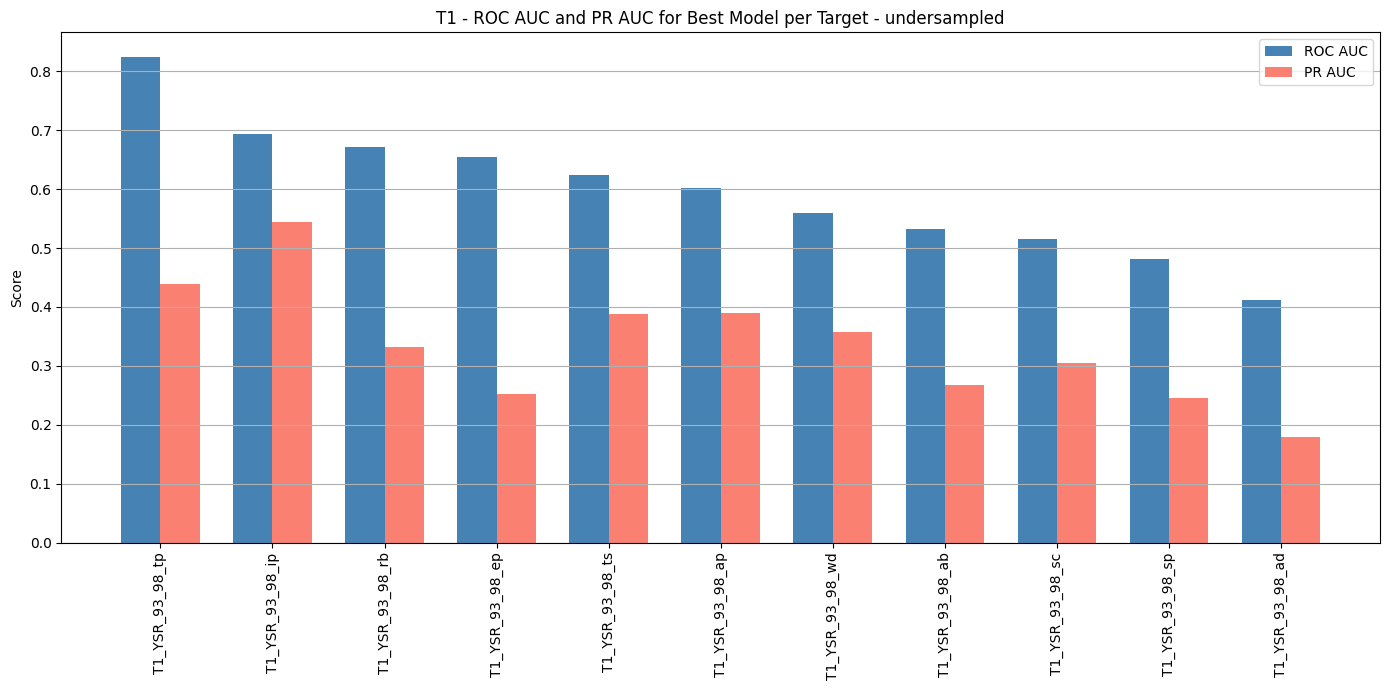

In [86]:
import pandas as pd

df_results = pd.read_csv("logistic_regression_metrics_all_targets_T1_UNDERSAMPLING.csv")
df_valid = df_results.dropna(subset=["PR AUC", "F1"])

best_models = (
    df_valid
    .sort_values(by=["Target", "PR AUC", "F1"], ascending=[True, False, False])
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)
import matplotlib.pyplot as plt

# Sort for better visualization
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("T1 - ROC AUC and PR AUC for Best Model per Target - undersampled")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()